# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

import random
import time 

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# magic word for producing visualizations in notebook
%matplotlib inline

# Make the images larger
plt.rcParams['figure.figsize'] = (16, 9)

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

In [2]:
print('pandas version is',pd.__version__)
print('numpy version is',np.__version__)

pandas version is 1.1.3
numpy version is 1.18.5


<img src="./cluster_analysis.png">

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [3]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv',sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv',sep=';')

In [4]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
print(azdias.shape)
azdias.head()


(891221, 85)


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,4,0,10.0,0,-1,15.0,4.0,2.0,2.0,1.0,1.0,0,0,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,-1,NaN,NaN,-1,3,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,1,1996,10.0,0,3,21.0,6.0,5.0,3.0,2.0,1.0,1,14,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3,1.0,0.0,2,5,0.0,2.0,0.0,6.0,NaN,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,5.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,1,1979,10.0,1,3,3.0,1.0,1.0,1.0,3.0,2.0,1,15,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2,0.0,0.0,1,5,17.0,1.0,0.0,4.0,NaN,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,6,1957,1.0,0,2,0.0,0.0,0.0,0.0,9.0,4.0,1,8,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,1,0.0,0.0,1,3,13.0,0.0,0.0,1.0,NaN,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,W,7.0,2,2A,12,4.0,1.0,0.0,0.0,1.0,4.0,4.0,2.0,6.0,4.0,0.0,4.0,1.0,0.0,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,5,1963,5.0,0,3,32.0,10.0,10.0,5.0,3.0,2.0,1,8,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,2,0.0,0.0,2,4,20.0,4.0,0.0,5.0,1.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,W,3.0,6,6B,43,1.0,4.0,1.0,0.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [5]:
print(feat_info.shape)
feat_info.head()

(85, 4)


,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [6]:
feat_info.missing_or_unknown.unique()

array(['[-1,0]', '[-1,0,9]', '[0]', '[-1]', '[]', '[-1,9]', '[-1,X]',
       '[XX]', '[-1,XX]'], dtype=object)

In [7]:
# Identify missing or unknown data values and convert them to NaNs.

NaN_before = azdias.isna().sum().sum()
print('NaN count before processing: {}'.format(NaN_before))

for attribute in feat_info['attribute']:
    null_list = feat_info[feat_info['attribute']==attribute].missing_or_unknown.iloc[0][1:-1].split(',')
    missing_or_unknown_list = [float(x) if x not in ['','X','XX'] else x for x in null_list]
    azdias[attribute].replace(to_replace=missing_or_unknown_list, value=np.nan, inplace=True)

NaN_after = azdias.isna().sum().sum()
print('NaN count after processing: {}'.format(NaN_after))
print('Total number of added NaN values = {}.'.format(NaN_after-NaN_before))

NaN count before processing: 4896838
NaN count after processing: 8373929
Total number of added NaN values = 3477091.


In [8]:
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1,2.0,3,4,3,5,5,3,4,NaN,10.0,0,NaN,15.0,4.0,2.0,2.0,1.0,1.0,NaN,NaN,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,NaN,NaN,NaN,NaN,3,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2,5.0,1,5,2,5,4,5,1,1996.0,10.0,0,3.0,21.0,6.0,5.0,3.0,2.0,1.0,1.0,14.0,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3.0,1.0,NaN,2.0,5,NaN,2.0,0.0,6.0,NaN,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,5.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2,3.0,1,4,1,2,3,5,1,1979.0,10.0,1,3.0,3.0,1.0,1.0,1.0,3.0,2.0,1.0,15.0,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2.0,0.0,NaN,1.0,5,17.0,1.0,0.0,4.0,NaN,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,NaN,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2,2.0,4,2,5,2,1,2,6,1957.0,1.0,0,2.0,NaN,NaN,NaN,NaN,9.0,4.0,1.0,8.0,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,1.0,0.0,NaN,1.0,3,13.0,0.0,0.0,1.0,NaN,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,W,7.0,2,2A,12,4.0,1.0,0.0,0.0,1.0,4.0,4.0,2.0,6.0,4.0,NaN,4.0,1.0,NaN,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1,5.0,4,3,4,1,3,2,5,1963.0,5.0,0,3.0,32.0,10.0,10.0,5.0,3.0,2.0,1.0,8.0,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,2.0,0.0,NaN,2.0,4,20.0,4.0,0.0,5.0,1.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,W,3.0,6,6B,43,1.0,4.0,1.0,0.0,NaN,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [9]:
azdias.tail()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
891216,NaN,3.0,2,5.0,1,4,2,5,4,4,1,1976.0,12.0,0,3.0,2.0,1.0,1.0,1.0,2.0,1.0,1.0,14.0,3.0,2,1,3,3,2,1,6,3,4,4,7,5,4,2,3.0,0.0,NaN,1.0,4,17.0,1.0,0.0,4.0,3.0,3.0,4.0,15.0,0.0,8.0,3.0,1992.0,W,3.0,7,7A,41,2.0,1.0,0.0,0.0,NaN,4.0,6.0,3.0,7.0,4.0,3.0,5.0,5.0,5.0,282.0,3.0,2.0,0.0,0.0,1.0,2.0,3.0,NaN,NaN,NaN
891217,NaN,2.0,1,4.0,3,3,3,2,2,3,6,1970.0,1.0,0,NaN,2.0,1.0,1.0,1.0,1.0,1.0,NaN,10.0,5.0,4,4,7,5,4,7,7,4,4,4,4,4,6,2,NaN,0.0,NaN,NaN,6,16.0,1.0,0.0,6.0,NaN,6.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,5.0,9,9D,51,0.0,0.0,1.0,1.0,5.0,2.0,7.0,6.0,2.0,3.0,3.0,1.0,2.0,7.0,592.0,1.0,3.0,3.0,2.0,4.0,5.0,3.0,4.0,6.0,5.0
891218,NaN,2.0,2,4.0,2,4,2,5,4,3,1,1976.0,10.0,0,1.0,NaN,NaN,NaN,NaN,4.0,2.0,1.0,14.0,4.0,5,2,5,3,2,3,5,5,7,4,4,5,6,7,2.0,0.0,NaN,1.0,4,17.0,0.0,0.0,5.0,NaN,NaN,5.0,3.0,0.0,8.0,6.0,1992.0,W,7.0,4,4C,24,1.0,3.0,1.0,0.0,NaN,3.0,5.0,2.0,6.0,4.0,3.0,2.0,3.0,5.0,688.0,4.0,2.0,0.0,0.0,1.0,3.0,4.0,2.0,2.0,3.0
891219,NaN,1.0,1,3.0,1,5,3,5,5,5,1,1994.0,9.0,0,1.0,29.0,9.0,9.0,5.0,2.0,1.0,1.0,14.0,4.0,7,7,7,5,6,3,2,7,5,2,2,2,7,5,0.0,0.0,NaN,2.0,5,NaN,1.0,0.0,6.0,NaN,1.0,9.0,7.0,0.0,8.0,2.0,1992.0,W,5.0,9,9D,51,0.0,3.0,2.0,0.0,NaN,3.0,2.0,6.0,4.0,4.0,4.0,1.0,3.0,7.0,134.0,1.0,4.0,3.0,1.0,5.0,1.0,1.0,4.0,7.0,5.0
891220,NaN,4.0,1,1.0,4,2,5,2,1,5,6,NaN,12.0,0,2.0,6.0,2.0,1.0,1.0,1.0,1.0,1.0,3.0,1.0,6,6,3,4,6,5,3,6,3,3,3,2,2,2,2.0,0.0,NaN,1.0,3,NaN,1.0,0.0,5.0,NaN,6.0,3.0,10.0,0.0,8.0,3.0,1992.0,W,4.0,6,6B,43,1.0,3.0,1.0,1.0,NaN,2.0,6.0,2.0,8.0,4.0,4.0,3.0,0.0,6.0,728.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,4.0,5.0


In [10]:
azdias.duplicated().sum()

52494

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [11]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

col_nan = azdias.isna().sum(axis=0)
print(col_nan)

AGER_TYP                685843
ALTERSKATEGORIE_GROB      2881
ANREDE_KZ                    0
CJT_GESAMTTYP             4854
FINANZ_MINIMALIST            0
                         ...  
PLZ8_HHZ                116515
PLZ8_GBZ                116515
ARBEIT                   97375
ORTSGR_KLS9              97274
RELAT_AB                 97375
Length: 85, dtype: int64


In [12]:
# outlier/non-outlier detector fuction
def detect_outlier(data):
    outliers=[]
    non_outliers=[]
    threshold=3
    mean = np.mean(data)
    std =np.std(data)
    
    for y in range(data.size):
        z_score= (data.iloc[y] - mean)/std
        if np.abs(z_score) > threshold:
            outliers.append(data.index[y])
        else:
            non_outliers.append(data.index[y])
    return outliers, non_outliers

In [13]:
# testing of function
outliers, _ = detect_outlier(col_nan)
print(outliers)
_ , non_outliers = detect_outlier(col_nan)
print(list(set(azdias.columns)-set(non_outliers)))

['AGER_TYP', 'TITEL_KZ', 'KK_KUNDENTYP']
['KK_KUNDENTYP', 'TITEL_KZ', 'AGER_TYP']


In [14]:
col_nan[col_nan == 0]
print('Below we notice (%s) columns with zero null values.\n\n'%(len(col_nan[col_nan == 0])))
print(col_nan[col_nan == 0])

Below we notice (24) columns with zero null values.


ANREDE_KZ                0
FINANZ_MINIMALIST        0
FINANZ_SPARER            0
FINANZ_VORSORGER         0
FINANZ_ANLEGER           0
FINANZ_UNAUFFAELLIGER    0
FINANZ_HAUSBAUER         0
FINANZTYP                0
GREEN_AVANTGARDE         0
SEMIO_SOZ                0
SEMIO_FAM                0
SEMIO_REL                0
SEMIO_MAT                0
SEMIO_VERT               0
SEMIO_LUST               0
SEMIO_ERL                0
SEMIO_KULT               0
SEMIO_RAT                0
SEMIO_KRIT               0
SEMIO_DOM                0
SEMIO_KAEM               0
SEMIO_PFLICHT            0
SEMIO_TRADV              0
ZABEOTYP                 0
dtype: int64


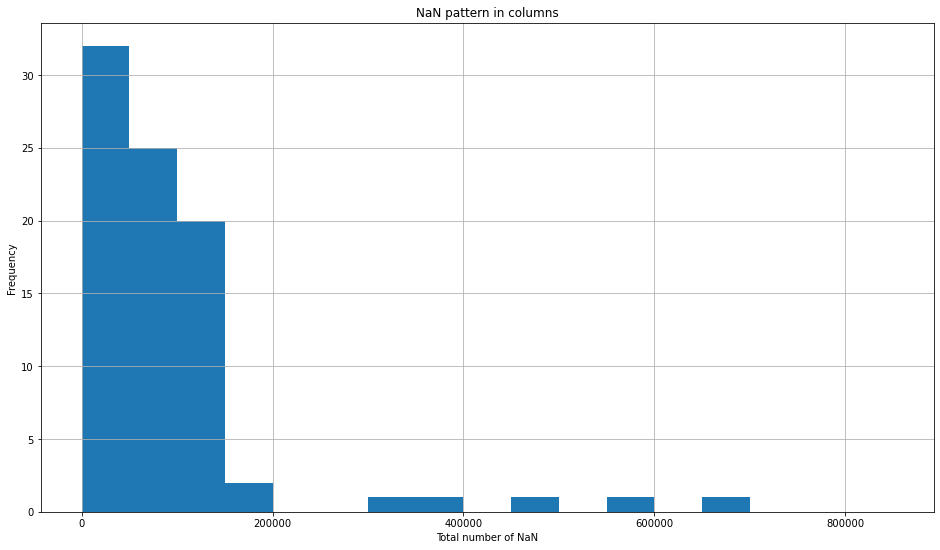

In [15]:
# Investigate patterns in the amount of missing data in each column.

plt.hist(col_nan, bins=np.arange(0,900000,step=50000))
plt.xlabel('Total number of NaN')
plt.ylabel('Frequency')
plt.title('NaN pattern in columns')
plt.grid()
plt.show()

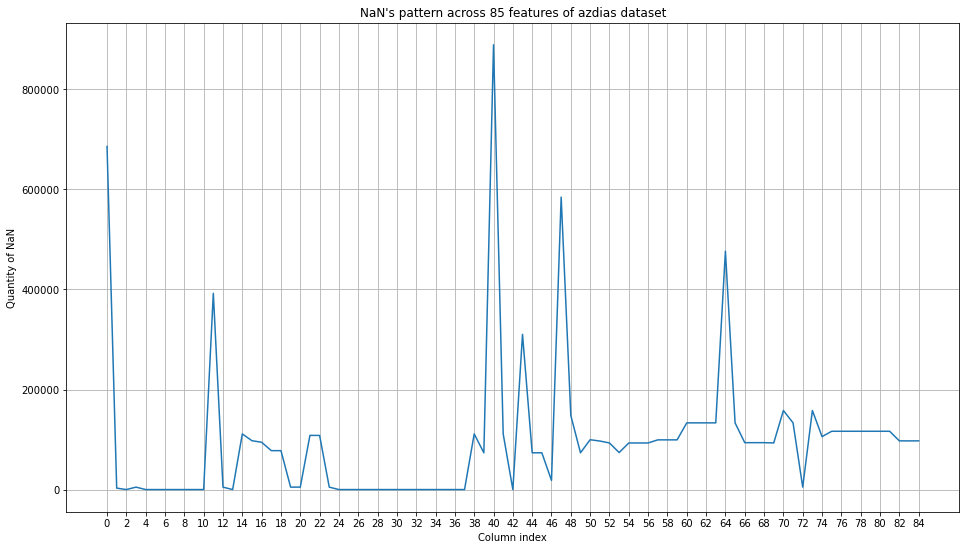

In [16]:
# another visualization of the null values for columns 0:84
#plt.figure(figsize=(20,5))
plt.plot(col_nan.values)
plt.xticks(np.arange(0,84+1,2))
plt.xlabel('Column index')
plt.ylabel('Quantity of NaN')
plt.title('NaN\'s pattern across 85 features of azdias dataset')
plt.grid()

In [17]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

col_outliers, _ = detect_outlier(col_nan)
azdias.drop(columns=col_outliers, axis=1, inplace=True)
print(azdias.shape)
azdias.head()

(891221, 82)


,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1,2.0,3,4,3,5,5,3,4,NaN,10.0,0,NaN,15.0,4.0,2.0,2.0,1.0,1.0,NaN,NaN,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,NaN,NaN,NaN,3,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2,5.0,1,5,2,5,4,5,1,1996.0,10.0,0,3.0,21.0,6.0,5.0,3.0,2.0,1.0,1.0,14.0,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3.0,1.0,2.0,5,NaN,2.0,0.0,6.0,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,5.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,3.0,1,4,1,2,3,5,1,1979.0,10.0,1,3.0,3.0,1.0,1.0,1.0,3.0,2.0,1.0,15.0,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2.0,0.0,1.0,5,17.0,1.0,0.0,4.0,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,NaN,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,2.0,4,2,5,2,1,2,6,1957.0,1.0,0,2.0,NaN,NaN,NaN,NaN,9.0,4.0,1.0,8.0,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,1.0,0.0,1.0,3,13.0,0.0,0.0,1.0,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,W,7.0,2,2A,12,4.0,1.0,0.0,0.0,1.0,4.0,4.0,2.0,6.0,4.0,NaN,4.0,1.0,NaN,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1,5.0,4,3,4,1,3,2,5,1963.0,5.0,0,3.0,32.0,10.0,10.0,5.0,3.0,2.0,1.0,8.0,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,2.0,0.0,2.0,4,20.0,4.0,0.0,5.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,W,3.0,6,6B,43,1.0,4.0,1.0,0.0,NaN,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


#### Discussion 1.1.2: Assess Missing Data in Each Column

> 1. NaN count was almost doubled after reflecting feat_info['missing_or_unknown'] knowledge on azdias dataset.
> 2. Only 24 out of 85 features were clean of any NaN's
> 3. Based on detect_outlier function, 3 features were dropped as the count of NaN's exceeded a limit of defined threshold of abs(z_score) = 3.
> 4. Some features had little to no NaN's while others had many.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [18]:
# How much data is missing in each row of the dataset?

row_nan = azdias.isna().sum(axis=1)
print(row_nan)

0         46
1          1
2          1
3          7
4          1
          ..
891216     4
891217     4
891218     6
891219     2
891220     3
Length: 891221, dtype: int64


Notice that rows are indexed from 0 to 891220

In [19]:
row_nan[row_nan == 0]
print('Below we notice {} persons or {}% of the population are without null values.\n\n'.format(len(row_nan[row_nan == 0]),np.round(row_nan[row_nan == 0].shape[0]/azdias.shape[0]*100,2)))
print(row_nan[row_nan == 0])

Below we notice 193588 persons or 21.72% of the population are without null values.


10        0
32        0
33        0
37        0
41        0
         ..
891196    0
891197    0
891204    0
891206    0
891207    0
Length: 193588, dtype: int64


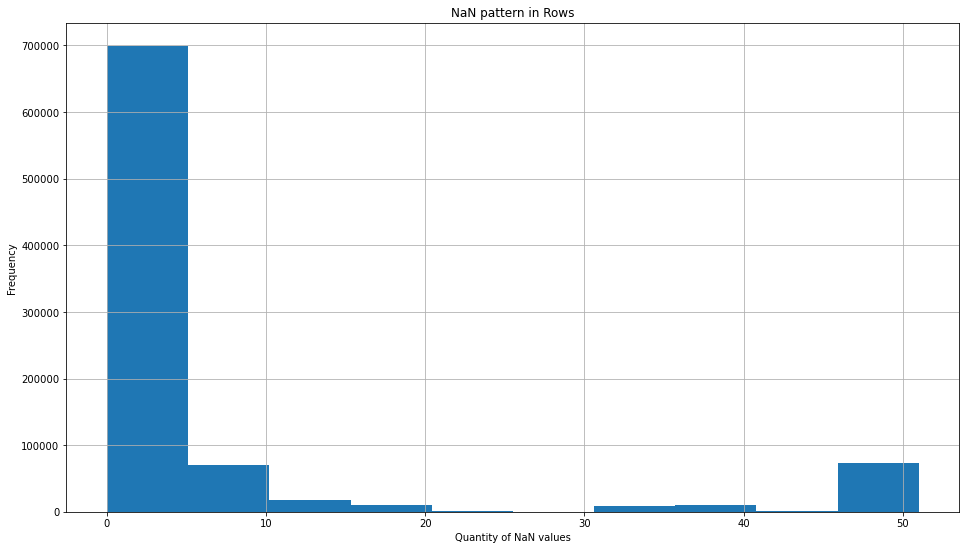

In [20]:
# hist visualization of null values per person
#plt.figure(figsize=(15,5))
plt.hist(row_nan)
plt.xlabel('Quantity of NaN values')
plt.ylabel('Frequency')
plt.title('NaN pattern in Rows')
plt.grid()
plt.show()

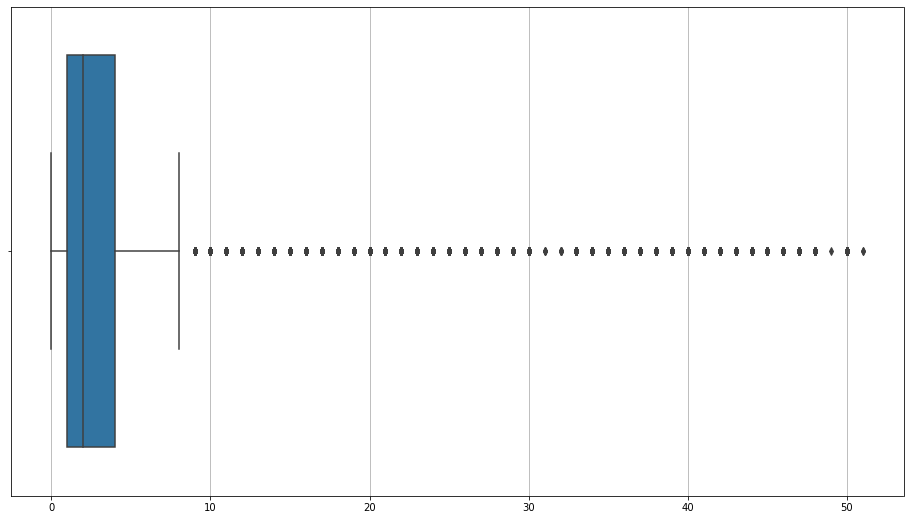

In [21]:
# another boxplot Visualization of null values per row
#plt.figure(figsize=(15,5))
sns.boxplot(x=row_nan, hue=row_nan.describe())
plt.grid(axis='x')

In [22]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

row_outliers, row_non_outliers = detect_outlier(row_nan)
below_threshold = azdias.drop(row_outliers) # below threshold
print('below_threshold.shape is',below_threshold.shape)
above_threshold = azdias.drop(row_non_outliers) # above threshold
print('above_threshold.shape is',above_threshold.shape)

below_threshold.shape is (845640, 82)
above_threshold.shape is (45581, 82)


In [23]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

sample_5_cols = azdias.dropna(axis=1).sample(5,axis=1).columns
sample_5_cols

Index(['SEMIO_DOM', 'ANREDE_KZ', 'SEMIO_REL', 'FINANZ_HAUSBAUER',
       'SEMIO_TRADV'],
      dtype='object')

In [24]:
below_threshold[sample_5_cols].head()

,SEMIO_DOM,ANREDE_KZ,SEMIO_REL,FINANZ_HAUSBAUER,SEMIO_TRADV
0,6,1,7,3,3
1,7,2,4,5,6
2,7,2,3,5,3
3,4,2,2,2,4
4,2,1,4,2,2


In [25]:
above_threshold[sample_5_cols].head()

,SEMIO_DOM,ANREDE_KZ,SEMIO_REL,FINANZ_HAUSBAUER,SEMIO_TRADV
11,6,1,7,3,3
14,6,1,7,3,3
17,6,1,7,3,3
24,6,2,7,3,3
48,6,2,7,3,3


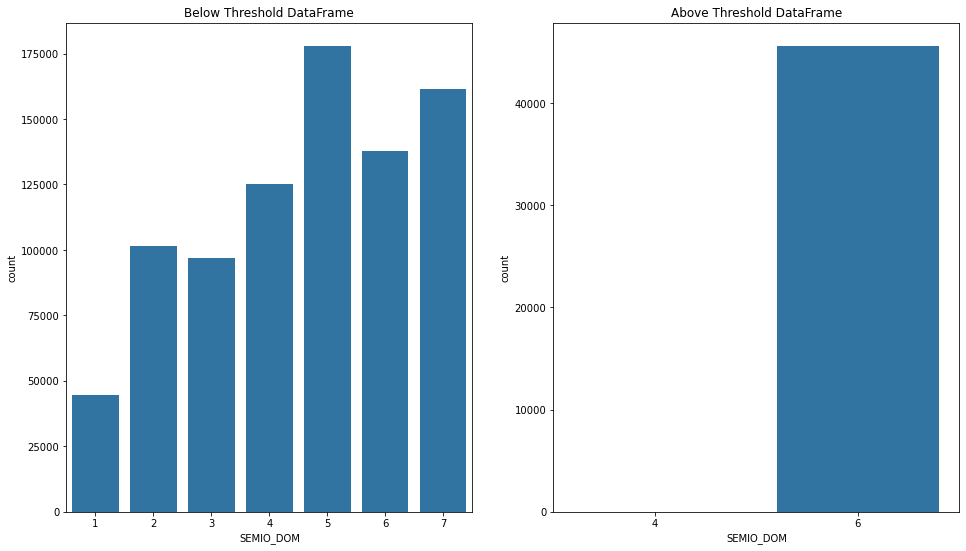

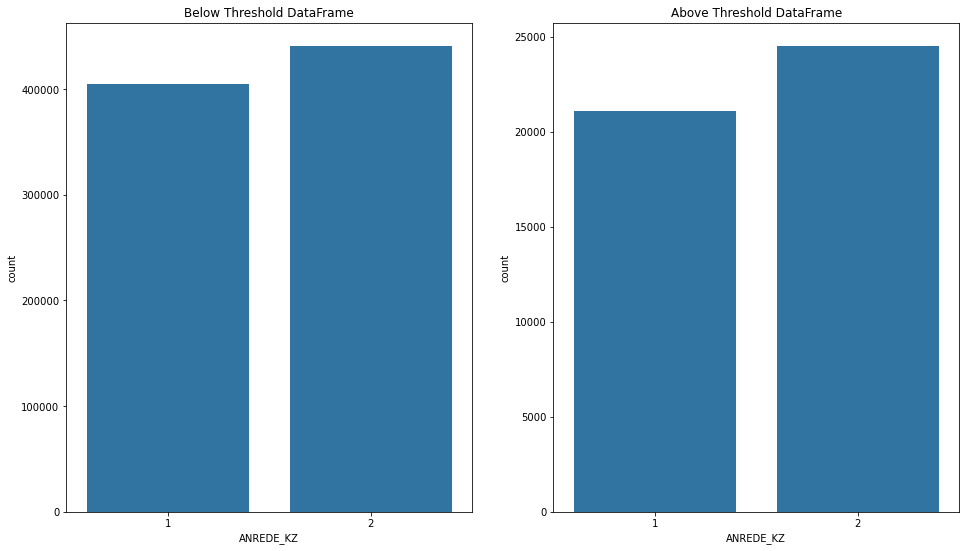

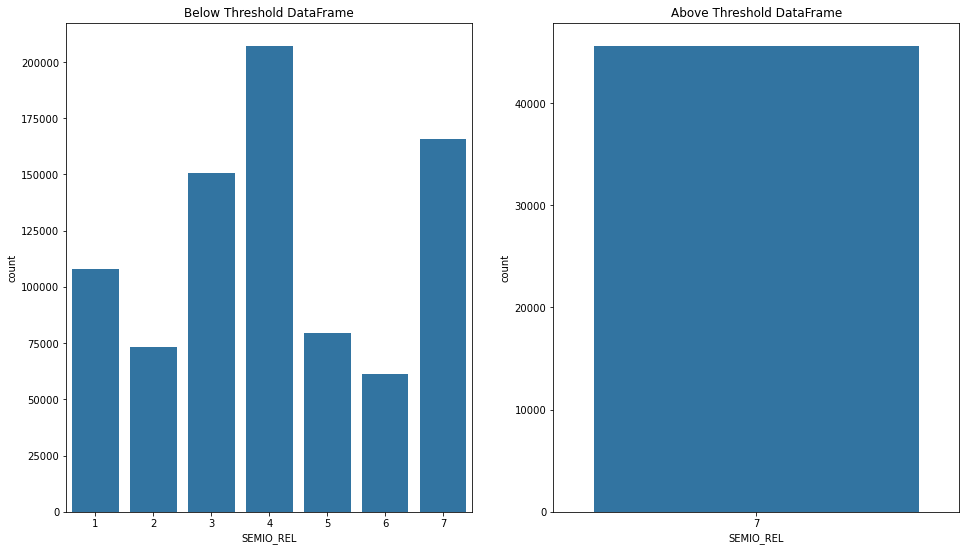

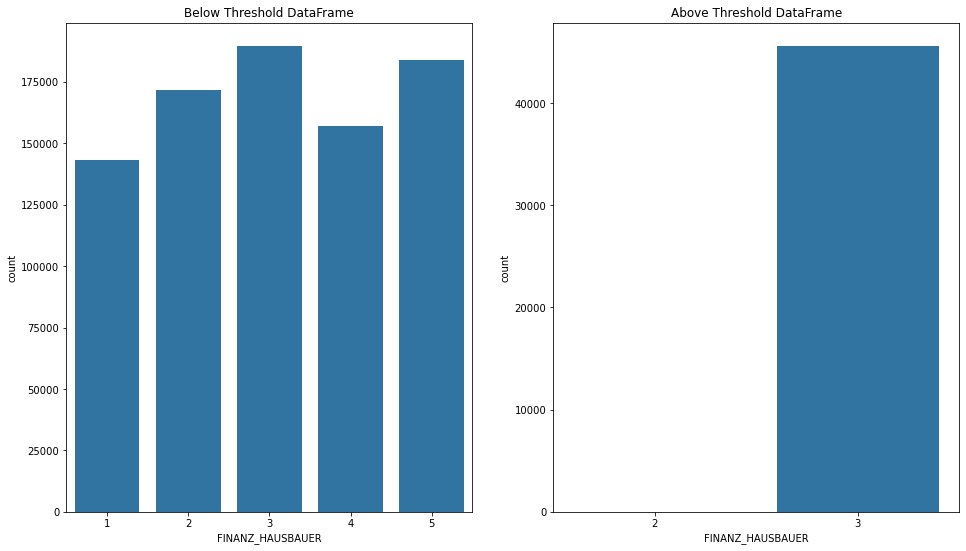

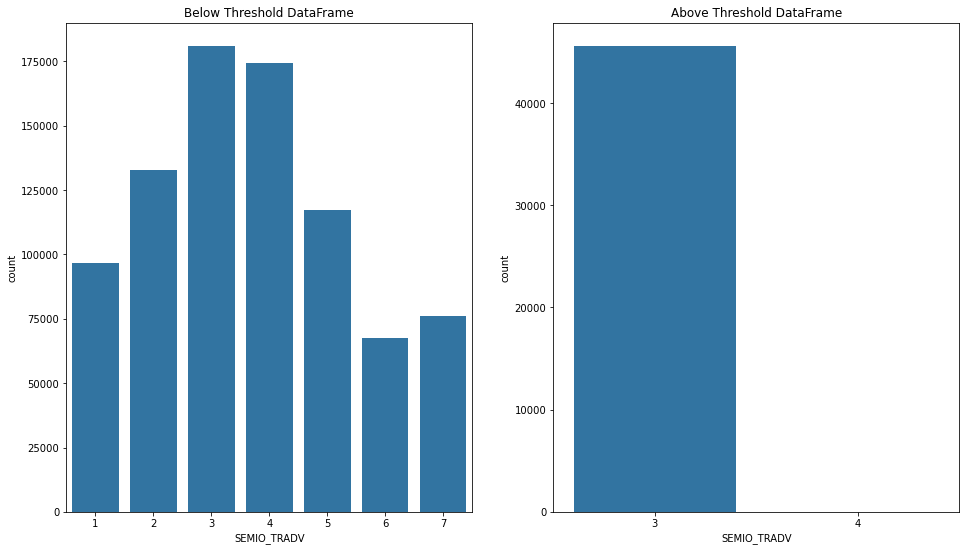

In [26]:
# visualize the two dataframes for better understanding of the distribution of data
def plot(column):
    if (below_threshold.shape[0]==0 or above_threshold.shape[0] ==0):
        pass
    else:
        #plt.figure(figsize=(10,5))
        ax1 = plt.subplot(1,2,1)
        ax1.set_title('Below Threshold DataFrame')
        sns.countplot(x=below_threshold[column], ax=ax1, color = sns.color_palette()[0])
        ax2 = plt.subplot(1,2,2)
        ax2.set_title('Above Threshold DataFrame')
        sns.countplot(x=above_threshold[column], ax=ax2, color = sns.color_palette()[0])
        plt.show()

for column in sample_5_cols:
    plot(column)

* I noticed a weird distribution of values in dataframe above_threshold where outlier rows were not dropped. Hence, it's more meaningfull to assigned azdias to below_threshold dataframe

In [27]:
# assign azdias to below thresold data frame
azdias = below_threshold

* So we will continue our analysis using this DataFrame **azdias** which has NaN values below a certain threshold.

#### Discussion 1.1.3: Assess Missing Data in Each Row

>1. I notice 193,588 persons or 21.72% of the population are without null values.
>2. NaN's in rows statistically had large outliers where 84,5640 (95%) of the instances lies below the threshold, the remaining 45,581 (5%) was above it.
>3. It was noticed that above_threshold dataset has a nonuniform (weird) distribution of values across it, e.g. only speicific values so these instances were dropped.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [28]:
# How many features are there of each data type?

print(feat_info.shape)
feat_info=feat_info[[x in azdias.columns for x in feat_info.attribute]]
print(feat_info.shape)
feat_info.head()

(85, 4)
(82, 4)


,attribute,information_level,type,missing_or_unknown
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]


In [29]:
feat_info[[x in azdias.columns for x in feat_info.attribute]].type.value_counts()

ordinal        49
categorical    18
mixed           7
numeric         7
interval        1
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [30]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

feat_info_cat = feat_info[[x in azdias.columns for x in feat_info.attribute]].query('type=="categorical"')
binary_cat = []
multi_cat = []
for feature in feat_info_cat.attribute:
    if azdias[feature].nunique()==2:
        binary_cat.append(feature)
    else:
        multi_cat.append(feature)

In [31]:
azdias[binary_cat].nunique()

ANREDE_KZ           2
GREEN_AVANTGARDE    2
SOHO_KZ             2
VERS_TYP            2
OST_WEST_KZ         2
dtype: int64

In [32]:
azdias[multi_cat].nunique()

CJT_GESAMTTYP        6
FINANZTYP            6
GFK_URLAUBERTYP     12
LP_FAMILIE_FEIN     11
LP_FAMILIE_GROB      5
LP_STATUS_FEIN      10
LP_STATUS_GROB       5
NATIONALITAET_KZ     3
SHOPPER_TYP          4
ZABEOTYP             6
GEBAEUDETYP          7
CAMEO_DEUG_2015      9
CAMEO_DEU_2015      44
dtype: int64

In [33]:
azdias[binary_cat].select_dtypes(['object']).columns

Index(['OST_WEST_KZ'], dtype='object')

In [34]:
azdias[binary_cat]

,ANREDE_KZ,GREEN_AVANTGARDE,SOHO_KZ,VERS_TYP,OST_WEST_KZ
0,1,0,NaN,NaN,NaN
1,2,0,1.0,2.0,W
2,2,1,0.0,1.0,W
3,2,0,0.0,1.0,W
4,1,0,0.0,2.0,W
...,...,...,...,...,...
891216,2,0,0.0,1.0,W
891217,1,0,0.0,NaN,W
891218,2,0,0.0,1.0,W
891219,1,0,0.0,2.0,W


In [35]:
# Re-encode categorical variable(s) to be kept in the analysis.

# first, we encode the binary_cat columns to 0's and 1's
cleanup_nums = {'ANREDE_KZ': {2:1,1:0},
                'VERS_TYP' : {1.0:0,2.0:1},
                'OST_WEST_KZ': {'W':0, 'O':1}}
azdias.replace(cleanup_nums, inplace=True)


# then we encode the multi_cat columns using get_dummies method

azdias=pd.get_dummies(data=azdias,columns=multi_cat)
print('azdias.shape:',azdias.shape)
azdias.info()

azdias.shape: (845640, 197)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 845640 entries, 0 to 891220
Columns: 197 entries, ALTERSKATEGORIE_GROB to CAMEO_DEU_2015_9E
dtypes: float64(46), int64(22), object(1), uint8(128)
memory usage: 594.8+ MB


In [36]:
azdias.select_dtypes(include='object').columns

Index(['CAMEO_INTL_2015'], dtype='object')

#### Discussion 1.2.1: Re-Encode Categorical Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding categorical features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)
* 4 numeric and 1 non-numeric binary features which were kept and encoded (when necessary) to 0/1.
* The other 13 multi-level categorical features were re-encoded using pd.get_dummies.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [37]:
feat_info.query('type == "mixed" ')

,attribute,information_level,type,missing_or_unknown
15,LP_LEBENSPHASE_FEIN,person,mixed,[0]
16,LP_LEBENSPHASE_GROB,person,mixed,[0]
22,PRAEGENDE_JUGENDJAHRE,person,mixed,"[-1,0]"
56,WOHNLAGE,building,mixed,[-1]
59,CAMEO_INTL_2015,microcell_rr4,mixed,"[-1,XX]"
64,KBA05_BAUMAX,microcell_rr3,mixed,"[-1,0]"
79,PLZ8_BAUMAX,macrocell_plz8,mixed,"[-1,0]"


In [38]:
azdias.PRAEGENDE_JUGENDJAHRE.unique()

array([nan, 14., 15.,  8.,  3., 10., 11.,  5.,  9.,  6.,  4.,  2.,  1.,
       12., 13.,  7.])

In [39]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

azdias[['PRAEGENDE_JUGENDJAHRE']].head()

,PRAEGENDE_JUGENDJAHRE
0,NaN
1,14.0
2,15.0
3,8.0
4,8.0


In [40]:
# based on Data_Dictionary.md

azdias["DECADE"]=azdias.PRAEGENDE_JUGENDJAHRE.replace({1:0,2:0,3:1,4:1,5:2,6:2,7:2,8:3,9:3,10:4,11:4,12:4,13:4,14:5,15:5})
azdias["MOVEMENT"]=azdias.PRAEGENDE_JUGENDJAHRE.replace({1:0,2:1,3:0,4:1,5:0,6:1,7:1,8:0,9:1,10:0,11:1,12:0,13:1,14:0,15:1})
azdias.filter(items=['PRAEGENDE_JUGENDJAHRE', 'DECADE','MOVEMENT']).head()

,PRAEGENDE_JUGENDJAHRE,DECADE,MOVEMENT
0,NaN,NaN,NaN
1,14.0,5.0,0.0
2,15.0,5.0,1.0
3,8.0,3.0,0.0
4,8.0,3.0,0.0


In [41]:
azdias.drop(columns=['PRAEGENDE_JUGENDJAHRE'], inplace=True)
azdias.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GEBURTSJAHR,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,FINANZTYP_1,FINANZTYP_2,FINANZTYP_3,FINANZTYP_4,FINANZTYP_5,FINANZTYP_6,GFK_URLAUBERTYP_1.0,GFK_URLAUBERTYP_2.0,GFK_URLAUBERTYP_3.0,GFK_URLAUBERTYP_4.0,GFK_URLAUBERTYP_5.0,GFK_URLAUBERTYP_6.0,GFK_URLAUBERTYP_7.0,GFK_URLAUBERTYP_8.0,GFK_URLAUBERTYP_9.0,GFK_URLAUBERTYP_10.0,GFK_URLAUBERTYP_11.0,GFK_URLAUBERTYP_12.0,LP_FAMILIE_FEIN_1.0,LP_FAMILIE_FEIN_2.0,LP_FAMILIE_FEIN_3.0,LP_FAMILIE_FEIN_4.0,LP_FAMILIE_FEIN_5.0,LP_FAMILIE_FEIN_6.0,LP_FAMILIE_FEIN_7.0,LP_FAMILIE_FEIN_8.0,LP_FAMILIE_FEIN_9.0,LP_FAMILIE_FEIN_10.0,LP_FAMILIE_FEIN_11.0,LP_FAMILIE_GROB_1.0,LP_FAMILIE_GROB_2.0,LP_FAMILIE_GROB_3.0,LP_FAMILIE_GROB_4.0,LP_FAMILIE_GROB_5.0,LP_STATUS_FEIN_1.0,LP_STATUS_FEIN_2.0,LP_STATUS_FEIN_3.0,LP_STATUS_FEIN_4.0,LP_STATUS_FEIN_5.0,LP_STATUS_FEIN_6.0,LP_STATUS_FEIN_7.0,LP_STATUS_FEIN_8.0,LP_STATUS_FEIN_9.0,LP_STATUS_FEIN_10.0,LP_STATUS_GROB_1.0,LP_STATUS_GROB_2.0,LP_STATUS_GROB_3.0,LP_STATUS_GROB_4.0,LP_STATUS_GROB_5.0,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,ZABEOTYP_1,ZABEOTYP_2,ZABEOTYP_3,ZABEOTYP_4,ZABEOTYP_5,ZABEOTYP_6,GEBAEUDETYP_1.0,GEBAEUDETYP_2.0,GEBAEUDETYP_3.0,GEBAEUDETYP_4.0,GEBAEUDETYP_5.0,GEBAEUDETYP_6.0,GEBAEUDETYP_8.0,CAMEO_DEUG_2015_1,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,CAMEO_DEU_2015_1A,CAMEO_DEU_2015_1B,CAMEO_DEU_2015_1C,CAMEO_DEU_2015_1D,CAMEO_DEU_2015_1E,CAMEO_DEU_2015_2A,CAMEO_DEU_2015_2B,CAMEO_DEU_2015_2C,CAMEO_DEU_2015_2D,CAMEO_DEU_2015_3A,CAMEO_DEU_2015_3B,CAMEO_DEU_2015_3C,CAMEO_DEU_2015_3D,CAMEO_DEU_2015_4A,CAMEO_DEU_2015_4B,CAMEO_DEU_2015_4C,CAMEO_DEU_2015_4D,CAMEO_DEU_2015_4E,CAMEO_DEU_2015_5A,CAMEO_DEU_2015_5B,CAMEO_DEU_2015_5C,CAMEO_DEU_2015_5D,CAMEO_DEU_2015_5E,CAMEO_DEU_2015_5F,CAMEO_DEU_2015_6A,CAMEO_DEU_2015_6B,CAMEO_DEU_2015_6C,CAMEO_DEU_2015_6D,CAMEO_DEU_2015_6E,CAMEO_DEU_2015_6F,CAMEO_DEU_2015_7A,CAMEO_DEU_2015_7B,CAMEO_DEU_2015_7C,CAMEO_DEU_2015_7D,CAMEO_DEU_2015_7E,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,DECADE,MOVEMENT
0,2.0,0,3,4,3,5,5,3,NaN,0,NaN,15.0,4.0,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN
1,1.0,1,1,5,2,5,4,5,1996.0,0,3.0,21.0,6.0,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,1.0,1.0,NaN,2.0,0.0,6.0,3.0,9.0,11.0,0.0,1.0,1992.0,0.0,4.0,51,0.0,0.0,0.0,2.0,5.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,

In [42]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
print('data type is:',azdias.CAMEO_INTL_2015.dtype,'\n')
azdias[["CAMEO_INTL_2015"]].head()

data type is: object 



,CAMEO_INTL_2015
0,NaN
1,51
2,24
3,12
4,43


In [43]:
# based on Data_Dictionary.md
azdias["WEALTH"]=azdias.CAMEO_INTL_2015.replace({'11':0,'12':0,'13':0,'14':0,'15':0,
                                                 '21':1,'22':1,'23':1,'24':1,'25':1,
                                                 '31':2,'32':2,'33':2,'34':2,'35':2,
                                                 '41':3,'42':3,'43':3,'44':3,'45':3,
                                                 '51':4,'52':4,'53':4,'54':4,'55':4
                                                    })
azdias["LIFE_STAGE"]=azdias.CAMEO_INTL_2015.replace({'11':0,'12':1,'13':2,'14':3,'15':4,
                                                     '21':0,'22':1,'23':2,'24':3,'25':4,
                                                     '31':0,'32':1,'33':2,'34':3,'35':4,
                                                     '41':0,'42':1,'43':2,'44':3,'45':4,
                                                     '51':0,'52':1,'53':2,'54':3,'55':4
                                                        })
azdias.filter(items=['CAMEO_INTL_2015', 'WEALTH','LIFE_STAGE']).head()

,CAMEO_INTL_2015,WEALTH,LIFE_STAGE
0,NaN,NaN,NaN
1,51,4.0,0.0
2,24,1.0,3.0
3,12,0.0,1.0
4,43,3.0,2.0


In [44]:
azdias.drop(columns=['CAMEO_INTL_2015'], inplace=True)
azdias.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GEBURTSJAHR,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,FINANZTYP_1,FINANZTYP_2,FINANZTYP_3,FINANZTYP_4,FINANZTYP_5,FINANZTYP_6,GFK_URLAUBERTYP_1.0,GFK_URLAUBERTYP_2.0,GFK_URLAUBERTYP_3.0,GFK_URLAUBERTYP_4.0,GFK_URLAUBERTYP_5.0,GFK_URLAUBERTYP_6.0,GFK_URLAUBERTYP_7.0,GFK_URLAUBERTYP_8.0,GFK_URLAUBERTYP_9.0,GFK_URLAUBERTYP_10.0,GFK_URLAUBERTYP_11.0,GFK_URLAUBERTYP_12.0,LP_FAMILIE_FEIN_1.0,LP_FAMILIE_FEIN_2.0,LP_FAMILIE_FEIN_3.0,LP_FAMILIE_FEIN_4.0,LP_FAMILIE_FEIN_5.0,LP_FAMILIE_FEIN_6.0,LP_FAMILIE_FEIN_7.0,LP_FAMILIE_FEIN_8.0,LP_FAMILIE_FEIN_9.0,LP_FAMILIE_FEIN_10.0,LP_FAMILIE_FEIN_11.0,LP_FAMILIE_GROB_1.0,LP_FAMILIE_GROB_2.0,LP_FAMILIE_GROB_3.0,LP_FAMILIE_GROB_4.0,LP_FAMILIE_GROB_5.0,LP_STATUS_FEIN_1.0,LP_STATUS_FEIN_2.0,LP_STATUS_FEIN_3.0,LP_STATUS_FEIN_4.0,LP_STATUS_FEIN_5.0,LP_STATUS_FEIN_6.0,LP_STATUS_FEIN_7.0,LP_STATUS_FEIN_8.0,LP_STATUS_FEIN_9.0,LP_STATUS_FEIN_10.0,LP_STATUS_GROB_1.0,LP_STATUS_GROB_2.0,LP_STATUS_GROB_3.0,LP_STATUS_GROB_4.0,LP_STATUS_GROB_5.0,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,ZABEOTYP_1,ZABEOTYP_2,ZABEOTYP_3,ZABEOTYP_4,ZABEOTYP_5,ZABEOTYP_6,GEBAEUDETYP_1.0,GEBAEUDETYP_2.0,GEBAEUDETYP_3.0,GEBAEUDETYP_4.0,GEBAEUDETYP_5.0,GEBAEUDETYP_6.0,GEBAEUDETYP_8.0,CAMEO_DEUG_2015_1,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,CAMEO_DEU_2015_1A,CAMEO_DEU_2015_1B,CAMEO_DEU_2015_1C,CAMEO_DEU_2015_1D,CAMEO_DEU_2015_1E,CAMEO_DEU_2015_2A,CAMEO_DEU_2015_2B,CAMEO_DEU_2015_2C,CAMEO_DEU_2015_2D,CAMEO_DEU_2015_3A,CAMEO_DEU_2015_3B,CAMEO_DEU_2015_3C,CAMEO_DEU_2015_3D,CAMEO_DEU_2015_4A,CAMEO_DEU_2015_4B,CAMEO_DEU_2015_4C,CAMEO_DEU_2015_4D,CAMEO_DEU_2015_4E,CAMEO_DEU_2015_5A,CAMEO_DEU_2015_5B,CAMEO_DEU_2015_5C,CAMEO_DEU_2015_5D,CAMEO_DEU_2015_5E,CAMEO_DEU_2015_5F,CAMEO_DEU_2015_6A,CAMEO_DEU_2015_6B,CAMEO_DEU_2015_6C,CAMEO_DEU_2015_6D,CAMEO_DEU_2015_6E,CAMEO_DEU_2015_6F,CAMEO_DEU_2015_7A,CAMEO_DEU_2015_7B,CAMEO_DEU_2015_7C,CAMEO_DEU_2015_7D,CAMEO_DEU_2015_7E,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
0,2.0,0,3,4,3,5,5,3,NaN,0,NaN,15.0,4.0,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN
1,1.0,1,1,5,2,5,4,5,1996.0,0,3.0,21.0,6.0,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,1.0,1.0,NaN,2.0,0.0,6.0,3.0,9.0,11.0,0.0,1.0,1992.0,0.0,4.0,0.0,0.0,0.0,2.0,5.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0

#### Discussion 1.2.2: Engineer Mixed-Type Features

>1. DECADE feature extracted from PRAEGENDE_JUGENDJAHRE was encoded between 0-5 representing 6 decases between 1940s and 1990s.
>2. MOVEMENT feature extracted from PRAEGENDE_JUGENDJAHRE was encoded as 0/1 depending whether it is Mainstream (0) or Avantgarde (1)
>3. PRAEGENDE_JUGENDJAHRE was then dropped
>4. WEALTH feature extracted from CAMEO_INTL_2015 was encoded between 0-4 representing five classes: Wealthy Households (0), Prosperous Households (1), Comfortable Households (2), Less Affluent Households (3), Poorer Households (4).
>5. LIFE_STAGE feature extracted from CAMEO_INTL_2015 was encoded between 0-4 representing five classes: Pre-Family Couples & Singles (0), Young Couples With Children (1), Families With School Age Children (2), Older Families &  Mature Couples (3), Elders In Retirement (4).
>6. CAMEO_INTL_2015 was then dropped.
>7. I decided to drop the other mixed-type features.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [45]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

azdias.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 845640 entries, 0 to 891220
Columns: 199 entries, ALTERSKATEGORIE_GROB to LIFE_STAGE
dtypes: float64(49), int64(22), uint8(128)
memory usage: 607.8 MB


In [46]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

feat_info.query("type == 'mixed' ")[['attribute']]

,attribute
15,LP_LEBENSPHASE_FEIN
16,LP_LEBENSPHASE_GROB
22,PRAEGENDE_JUGENDJAHRE
56,WOHNLAGE
59,CAMEO_INTL_2015
64,KBA05_BAUMAX
79,PLZ8_BAUMAX


In [47]:
# Remove all remaining of mixed type features
# mixed_attributes = feat_info[[x in azdias.columns for x in feat_info.attribute]].query("type == 'mixed' ").attribute
# for attribute in mixed_attributes:
#     if attribute in azdias.columns:
#         azdias.drop(columns=attribute,inplace=True)
        
# -------- edit

mixed_attributes = feat_info[[x in azdias.columns for x in feat_info.attribute]].query("type == 'mixed' ").attribute
print(mixed_attributes)
azdias.drop(columns=mixed_attributes,inplace=True)

15    LP_LEBENSPHASE_FEIN
16    LP_LEBENSPHASE_GROB
56               WOHNLAGE
64           KBA05_BAUMAX
79            PLZ8_BAUMAX
Name: attribute, dtype: object


In [48]:
# verify dropped columns
azdias.filter(items=mixed_attributes.values).columns.size

0

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [49]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    
    # convert missing value codes into NaNs, ...
    feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv',sep=';')
    
    for attribute in feat_info['attribute']:
        null_list = feat_info[feat_info['attribute']==attribute].missing_or_unknown.iloc[0][1:-1].split(',')
        missing_or_unknown_list = [float(x) if x not in ['','X','XX'] else x for x in null_list]
        df[attribute].replace(to_replace=missing_or_unknown_list, value=np.nan, inplace=True)

    
    print('Pre-cleaned df shape: {}'.format(df.shape)) # print initial shape
    # remove selected columns and rows, ...
    
    # outlier/non-outlier detector fuction
    def detect_outlier(data):
        outliers=[]
        threshold=3
        mean = np.mean(data)
        std =np.std(data)

        for y in range(data.size):
            z_score= (data.iloc[y] - mean)/std
            if np.abs(z_score) > threshold:
                outliers.append(data.index[y])
        return outliers

    col_count_0 = df.shape[1]
    
    col_outliers = detect_outlier(df.isna().sum(axis=0))
    df.drop(columns=col_outliers, axis=1, inplace=True)
    col_count_1 = df.shape[1]
    print('{} columns were dropped based on NaN threshold'.format(col_count_0 - col_count_1))

    row_count_0 = df.shape[0]
    row_outliers = detect_outlier(df.isna().sum(axis=1))
    df.drop(row_outliers, axis=0, inplace=True)
    row_count_1 = df.shape[0]
    
    print('{} rows were dropped based on NaN threshold'.format(row_count_0 - row_count_1))

    # select, re-encode, and engineer column values.
    feat_info_cat = feat_info[[x in df.columns for x in feat_info.attribute]].query('type=="categorical"')
    binary_cat = []
    multi_cat = []
    for feature in feat_info_cat.attribute:
        if df[feature].nunique()==2:
            binary_cat.append(feature)
        else:
            multi_cat.append(feature)
    
    # binary-type categorical features
    binary_encoding = {'ANREDE_KZ': {1:0,2:1},
                       'VERS_TYP' : {1.0:0,2.0:1},
                       'OST_WEST_KZ': {'W':0, 'O':1}}
    df.replace(binary_encoding, inplace=True)
    
    # multi-level categorical features
    df = pd.get_dummies(data=df,columns=multi_cat)
    
    # mixed features
    df["DECADE"]=df.PRAEGENDE_JUGENDJAHRE.replace({1:0,2:0,3:1,4:1,5:2,6:2,7:2,8:3,9:3,10:4,11:4,12:4,13:4,14:5,15:5})
    df["MOVEMENT"]=df.PRAEGENDE_JUGENDJAHRE.replace({1:0,2:1,3:0,4:1,5:0,6:1,7:1,8:0,9:1,10:0,11:1,12:0,13:1,14:0,15:1})
    df.drop(columns=['PRAEGENDE_JUGENDJAHRE'], axis=1, inplace=True)
    
    df["WEALTH"]=azdias.CAMEO_INTL_2015.replace({'11':0,'12':0,'13':0,'14':0,'15':0,
                                                 '21':1,'22':1,'23':1,'24':1,'25':1,
                                                 '31':2,'32':2,'33':2,'34':2,'35':2,
                                                 '41':3,'42':3,'43':3,'44':3,'45':3,
                                                 '51':4,'52':4,'53':4,'54':4,'55':4
                                                    })
    df["LIFE_STAGE"]=azdias.CAMEO_INTL_2015.replace({'11':0,'12':1,'13':2,'14':3,'15':4,
                                                     '21':0,'22':1,'23':2,'24':3,'25':4,
                                                     '31':0,'32':1,'33':2,'34':3,'35':4,
                                                     '41':0,'42':1,'43':2,'44':3,'45':4,
                                                     '51':0,'52':1,'53':2,'54':3,'55':4
                                                        })
    df.drop(columns=['CAMEO_INTL_2015'],axis=1, inplace=True)
    
    feat_info=feat_info[[x in df.columns for x in feat_info.attribute]]
    mixed_attributes = feat_info.query("type == 'mixed' ").attribute
    for attribute in mixed_attributes:
        if attribute in df.columns:
            df.drop(columns=attribute,inplace=True)
        
    col_count_2 = df.shape[1]
    print('A total of {} columns were added'.format(col_count_2 - col_count_1))
    
    # use sklearn simple imputer impute NaN values
    X = SimpleImputer().fit_transform(df)
    df = pd.DataFrame(data=X, columns=df.columns)
    
    print('Post cleaning df shape: {}'.format(df.shape)) # print final shape
    
    # Return the cleaned dataframe.
    return df

In [50]:
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv',sep=';')
azdias_clean = clean_data(azdias)

# Investigate NaN's
print('NaN count:',azdias_clean.isna().sum().sum())

Pre-cleaned df shape: (891221, 85)
3 columns were dropped based on NaN threshold
45581 rows were dropped based on NaN threshold
A total of 112 columns were added
Post cleaning df shape: (845640, 194)
NaN count: 0


## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [51]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.



In [52]:
# Apply feature scaling to the general population demographics data.

scaler = StandardScaler()
X_scaled = scaler.fit_transform(azdias_clean)
azdias_scaled = pd.DataFrame(data=X_scaled, columns=azdias_clean.columns)
print(azdias_scaled.shape)
azdias_scaled.head()

(845640, 194)


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GEBURTSJAHR,GREEN_AVANTGARDE,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,FINANZTYP_1,FINANZTYP_2,FINANZTYP_3,FINANZTYP_4,FINANZTYP_5,FINANZTYP_6,GFK_URLAUBERTYP_1.0,GFK_URLAUBERTYP_2.0,GFK_URLAUBERTYP_3.0,GFK_URLAUBERTYP_4.0,GFK_URLAUBERTYP_5.0,GFK_URLAUBERTYP_6.0,GFK_URLAUBERTYP_7.0,GFK_URLAUBERTYP_8.0,GFK_URLAUBERTYP_9.0,GFK_URLAUBERTYP_10.0,GFK_URLAUBERTYP_11.0,GFK_URLAUBERTYP_12.0,LP_FAMILIE_FEIN_1.0,LP_FAMILIE_FEIN_2.0,LP_FAMILIE_FEIN_3.0,LP_FAMILIE_FEIN_4.0,LP_FAMILIE_FEIN_5.0,LP_FAMILIE_FEIN_6.0,LP_FAMILIE_FEIN_7.0,LP_FAMILIE_FEIN_8.0,LP_FAMILIE_FEIN_9.0,LP_FAMILIE_FEIN_10.0,LP_FAMILIE_FEIN_11.0,LP_FAMILIE_GROB_1.0,LP_FAMILIE_GROB_2.0,LP_FAMILIE_GROB_3.0,LP_FAMILIE_GROB_4.0,LP_FAMILIE_GROB_5.0,LP_STATUS_FEIN_1.0,LP_STATUS_FEIN_2.0,LP_STATUS_FEIN_3.0,LP_STATUS_FEIN_4.0,LP_STATUS_FEIN_5.0,LP_STATUS_FEIN_6.0,LP_STATUS_FEIN_7.0,LP_STATUS_FEIN_8.0,LP_STATUS_FEIN_9.0,LP_STATUS_FEIN_10.0,LP_STATUS_GROB_1.0,LP_STATUS_GROB_2.0,LP_STATUS_GROB_3.0,LP_STATUS_GROB_4.0,LP_STATUS_GROB_5.0,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,ZABEOTYP_1,ZABEOTYP_2,ZABEOTYP_3,ZABEOTYP_4,ZABEOTYP_5,ZABEOTYP_6,GEBAEUDETYP_1.0,GEBAEUDETYP_2.0,GEBAEUDETYP_3.0,GEBAEUDETYP_4.0,GEBAEUDETYP_5.0,GEBAEUDETYP_6.0,GEBAEUDETYP_8.0,CAMEO_DEUG_2015_1,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,CAMEO_DEU_2015_1A,CAMEO_DEU_2015_1B,CAMEO_DEU_2015_1C,CAMEO_DEU_2015_1D,CAMEO_DEU_2015_1E,CAMEO_DEU_2015_2A,CAMEO_DEU_2015_2B,CAMEO_DEU_2015_2C,CAMEO_DEU_2015_2D,CAMEO_DEU_2015_3A,CAMEO_DEU_2015_3B,CAMEO_DEU_2015_3C,CAMEO_DEU_2015_3D,CAMEO_DEU_2015_4A,CAMEO_DEU_2015_4B,CAMEO_DEU_2015_4C,CAMEO_DEU_2015_4D,CAMEO_DEU_2015_4E,CAMEO_DEU_2015_5A,CAMEO_DEU_2015_5B,CAMEO_DEU_2015_5C,CAMEO_DEU_2015_5D,CAMEO_DEU_2015_5E,CAMEO_DEU_2015_5F,CAMEO_DEU_2015_6A,CAMEO_DEU_2015_6B,CAMEO_DEU_2015_6C,CAMEO_DEU_2015_6D,CAMEO_DEU_2015_6E,CAMEO_DEU_2015_6F,CAMEO_DEU_2015_7A,CAMEO_DEU_2015_7B,CAMEO_DEU_2015_7C,CAMEO_DEU_2015_7D,CAMEO_DEU_2015_7E,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
0,-0.760038,-1.043465,-0.057920,0.841115,-0.312221,1.382988,1.556146,-0.056995,3.326997e-14,-0.511242,-6.122652e-16,1.075685,-1.055029,0.946497,1.489057,0.556130,-1.587327,0.326151,-0.857020,-0.557088,0.058381,1.307966,0.773312,0.878613,0.433510,-0.399470,-1.930249e-17,-2.312528e-16,1.691725e-15,-5.860719e-16,0.000000,-1.489230,1.061975e-15,-2.817939e-15,1.171373e-16,2.209691e-17,8.741534e-16,2.106841e-13,1.400003e-16,-1.670603e-16,1.883635e-16,2.314349e-16,-1.836049e-16,-1.058471e-15,-8.376607e-16,-5.320572e-16,-1.352351e-15,-4.951668e-16,0.000000,6.565862e-16,-1.121232,1.038885e-15,0.000000,-4.773370e-16,1.008303e-15,-2.351061e-16,-3.190426e-16,4.763770e-16,-1.669580e-15,-4.587734e-16,0.000000,-3.368885e-16,-0.363862,2.164083,-0.476449,-0.576536,-0.401463,-0.383323,-0.555790,-0.388439,-0.259503,2.990559,-0.379457,-0.723137,-0.260141,-0.241775,-0.266323,-0.285589,-0.310932,-0.182087,-0.231334,-

### Discussion 2.1: Apply Feature Scaling

> I applied standardization on the dataset before applying PCA or KMeans then fit_transform the clean dataset.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [53]:
def do_pca(n_components, data):
    '''
    Transforms data using PCA to create n_components, and provides back the results of the
    transformation.

    INPUT: n_components - int - the number of principal components to create
           data - the data you would like to transform

    OUTPUT: pca - the pca object created after fitting the data
            X_pca - the transformed X matrix with new number of components
    '''
    pca = PCA(n_components)
    X_pca = pca.fit_transform(data)
    return pca, X_pca

In [54]:
# Apply PCA to the data

start_time = time.time()

pca, azdias_pca = do_pca(None, azdias_scaled)

print("--- Run time: %s mins ---" % np.round(((time.time() - start_time)/60),2))

--- Run time: 0.19 mins ---


In [55]:
azdias_pca

array([[ 9.40237487e-01, -4.26221022e-01, -1.24281689e+00, ...,
         7.82365487e-15,  4.77363075e-15,  9.11656504e-16],
       [ 5.32445625e+00, -3.84257497e+00, -2.83188066e+00, ...,
         3.59279305e-14,  1.20062448e-15, -1.36099474e-15],
       [-3.93638756e-01, -1.05725334e+00, -3.23037199e+00, ...,
         1.47854895e-14,  2.47155685e-15,  2.72054588e-15],
       ...,
       [-6.24166415e-01, -4.12690677e+00, -3.02829770e+00, ...,
         2.74208493e-17, -2.64441187e-17, -1.14870497e-17],
       [ 6.77518725e+00, -4.01994648e+00,  3.06750583e+00, ...,
        -2.56838375e-17, -2.18011881e-17,  3.80255554e-18],
       [ 4.86881156e-01,  2.77335079e+00,  2.09690139e+00, ...,
         3.97939886e-17,  2.13095502e-17, -2.00435109e-18]])

In [56]:
azdias_pca.shape

(845640, 194)

In [57]:
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components = len(pca.explained_variance_ratio_)
    ind = np.arange(0,num_components)
    vals = pca.explained_variance_ratio_*100
    cumvals = np.cumsum(vals)
    
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    
    ax1.bar(ind, vals, color='r')
    ax2.plot(ind, cumvals, color='b')
    for i in range(0,num_components, int(num_components/15)):
        ax1.annotate(r"%s%%" % ((str(vals[i])[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax1.xaxis.set_tick_params(width=0)
    ax1.yaxis.set_tick_params(width=2, length=12)
 
    ax1.set_xlabel("Number of Principal Components", fontsize=14)
    ax1.set_ylabel("Variance Explained (%)", color='r', fontsize=14)
    ax2.set_ylabel("Cumulative Explained Variance (%)", color='b', fontsize=14)
    plt.title('"Explained Variance Per Principal Component"', fontsize=18)
    plt.grid()
    plt.show()

In [58]:
pca.explained_variance_ratio_

array([7.74029417e-02, 5.99982236e-02, 3.47552099e-02, 2.66453274e-02,
       2.04529841e-02, 1.56382725e-02, 1.48316824e-02, 1.33674451e-02,
       1.30117602e-02, 1.27617022e-02, 1.23268947e-02, 1.18167501e-02,
       1.15474630e-02, 1.14141373e-02, 1.12211358e-02, 1.10007603e-02,
       1.08344327e-02, 1.06937493e-02, 1.04967434e-02, 1.03226969e-02,
       1.00775248e-02, 9.99633981e-03, 9.66263751e-03, 9.30637824e-03,
       8.91260314e-03, 8.55461423e-03, 8.36499431e-03, 7.91563767e-03,
       7.69337487e-03, 7.26325464e-03, 7.17792965e-03, 6.95786692e-03,
       6.84410425e-03, 6.70366389e-03, 6.62526781e-03, 6.61691272e-03,
       6.50961984e-03, 6.29521483e-03, 6.22103683e-03, 6.13790315e-03,
       6.10192216e-03, 5.96866456e-03, 5.85939175e-03, 5.76662889e-03,
       5.74968517e-03, 5.73276559e-03, 5.66792340e-03, 5.63131865e-03,
       5.57499936e-03, 5.55937904e-03, 5.50190823e-03, 5.47637052e-03,
       5.43270581e-03, 5.39327164e-03, 5.38907103e-03, 5.37037632e-03,
      

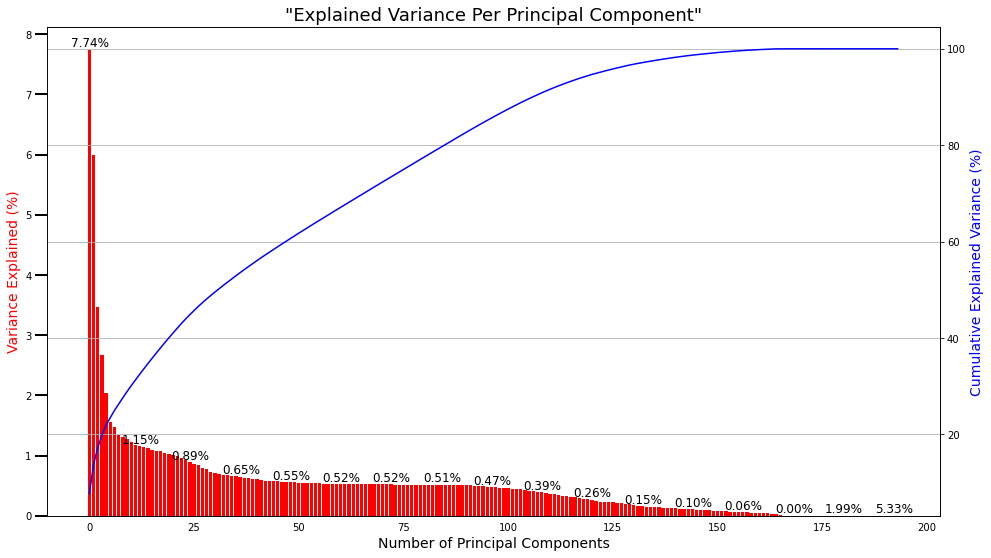

In [59]:
# Visualizes the PCA results
scree_plot(pca)

In [60]:
def pca_results(full_dataset, pca):
    '''
    Create a DataFrame of the PCA results
    Includes dimension feature weights and explained variance
    Visualizes the PCA results
    '''

    # Dimension indexing
    dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]

    # PCA components
    components = pd.DataFrame(np.round(pca.components_, 4), columns = full_dataset.keys())
    components.index = dimensions

    # PCA explained variance
    ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
    variance_ratios.index = dimensions

    # Return a concatenated DataFrame
    return pd.concat([variance_ratios, components], axis = 1)

In [61]:
azdias_scaled.shape

(845640, 194)

In [62]:
# select n_components that explains 80% (or more) of the variance

start_time = time.time()

for comp in range(85, azdias_scaled.shape[1]):
    pca, azdias_pca = do_pca(comp, azdias_scaled)
    comp_check = pca_results(azdias_scaled, pca)
    if comp_check['Explained Variance'].sum() >= 0.80:
        break
        

num_comps = comp_check.shape[0]
perc_exp = round(comp_check['Explained Variance'].sum()*100,2)
print("Using {} components, we can explain {}% of the variability in the original dataset.\n\n".format(num_comps,perc_exp))

print("--- Run time: %s mins ---" % np.round(((time.time() - start_time)/60),2))

Using 87 components, we can explain 80.36% of the variability in the original dataset.


--- Run time: 1.42 mins ---


In [63]:
# Re-apply PCA to the data while selecting for number of components to retain.

start_time = time.time()

pca, azdias_pca = do_pca(87, azdias_scaled)

print("--- Run time: %s mins ---" % np.round(((time.time() - start_time)/60),2))

--- Run time: 0.46 mins ---


In [64]:
azdias_pca.shape

(845640, 87)

* Total population = 845640 rows
* Number of PCA features that explains 80% (or more) of the variance = 86 columns

### Discussion 2.2: Perform Dimensionality Reduction

>1. I applied PCA without specifying the number of components to then visually analyze the amount of variance explained cumulatively while increasing the number of principal components. 
>2. Then I chose the number (86) that explains at least 80% of the variance using looped functions and re-apply it in another PCA using the do_pca function.
>3. To emphasise, the number of components retained is 86 explaining 80% (or more) of the total variance.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [65]:
components = pd.DataFrame(np.round(pca.components_, 4), columns=azdias_clean.keys())
print('components.shape:',components.shape)
components.head()

components.shape: (87, 194)


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GEBURTSJAHR,GREEN_AVANTGARDE,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,FINANZTYP_1,FINANZTYP_2,FINANZTYP_3,FINANZTYP_4,FINANZTYP_5,FINANZTYP_6,GFK_URLAUBERTYP_1.0,GFK_URLAUBERTYP_2.0,GFK_URLAUBERTYP_3.0,GFK_URLAUBERTYP_4.0,GFK_URLAUBERTYP_5.0,GFK_URLAUBERTYP_6.0,GFK_URLAUBERTYP_7.0,GFK_URLAUBERTYP_8.0,GFK_URLAUBERTYP_9.0,GFK_URLAUBERTYP_10.0,GFK_URLAUBERTYP_11.0,GFK_URLAUBERTYP_12.0,LP_FAMILIE_FEIN_1.0,LP_FAMILIE_FEIN_2.0,LP_FAMILIE_FEIN_3.0,LP_FAMILIE_FEIN_4.0,LP_FAMILIE_FEIN_5.0,LP_FAMILIE_FEIN_6.0,LP_FAMILIE_FEIN_7.0,LP_FAMILIE_FEIN_8.0,LP_FAMILIE_FEIN_9.0,LP_FAMILIE_FEIN_10.0,LP_FAMILIE_FEIN_11.0,LP_FAMILIE_GROB_1.0,LP_FAMILIE_GROB_2.0,LP_FAMILIE_GROB_3.0,LP_FAMILIE_GROB_4.0,LP_FAMILIE_GROB_5.0,LP_STATUS_FEIN_1.0,LP_STATUS_FEIN_2.0,LP_STATUS_FEIN_3.0,LP_STATUS_FEIN_4.0,LP_STATUS_FEIN_5.0,LP_STATUS_FEIN_6.0,LP_STATUS_FEIN_7.0,LP_STATUS_FEIN_8.0,LP_STATUS_FEIN_9.0,LP_STATUS_FEIN_10.0,LP_STATUS_GROB_1.0,LP_STATUS_GROB_2.0,LP_STATUS_GROB_3.0,LP_STATUS_GROB_4.0,LP_STATUS_GROB_5.0,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,ZABEOTYP_1,ZABEOTYP_2,ZABEOTYP_3,ZABEOTYP_4,ZABEOTYP_5,ZABEOTYP_6,GEBAEUDETYP_1.0,GEBAEUDETYP_2.0,GEBAEUDETYP_3.0,GEBAEUDETYP_4.0,GEBAEUDETYP_5.0,GEBAEUDETYP_6.0,GEBAEUDETYP_8.0,CAMEO_DEUG_2015_1,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,CAMEO_DEU_2015_1A,CAMEO_DEU_2015_1B,CAMEO_DEU_2015_1C,CAMEO_DEU_2015_1D,CAMEO_DEU_2015_1E,CAMEO_DEU_2015_2A,CAMEO_DEU_2015_2B,CAMEO_DEU_2015_2C,CAMEO_DEU_2015_2D,CAMEO_DEU_2015_3A,CAMEO_DEU_2015_3B,CAMEO_DEU_2015_3C,CAMEO_DEU_2015_3D,CAMEO_DEU_2015_4A,CAMEO_DEU_2015_4B,CAMEO_DEU_2015_4C,CAMEO_DEU_2015_4D,CAMEO_DEU_2015_4E,CAMEO_DEU_2015_5A,CAMEO_DEU_2015_5B,CAMEO_DEU_2015_5C,CAMEO_DEU_2015_5D,CAMEO_DEU_2015_5E,CAMEO_DEU_2015_5F,CAMEO_DEU_2015_6A,CAMEO_DEU_2015_6B,CAMEO_DEU_2015_6C,CAMEO_DEU_2015_6D,CAMEO_DEU_2015_6E,CAMEO_DEU_2015_6F,CAMEO_DEU_2015_7A,CAMEO_DEU_2015_7B,CAMEO_DEU_2015_7C,CAMEO_DEU_2015_7D,CAMEO_DEU_2015_7E,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
0,-0.0935,0.0139,-0.1951,0.1260,-0.0952,0.0656,0.0615,0.1432,0.0715,-0.1039,0.0286,-0.0172,0.0246,0.0571,0.0867,0.0595,-0.0437,-0.0565,-0.0548,0.0503,0.0772,0.0140,0.0258,0.0387,0.0929,0.0681,-0.0023,0.0232,0.0294,-0.0789,-0.0052,0.1749,0.0376,-0.0536,0.1143,0.0261,-0.1345,-0.0466,0.0410,-0.1903,0.0114,0.1141,0.1261,-0.1802,-0.0958,0.1523,-0.1266,-0.0964,0.0402,-0.2031,-0.0457,0.0624,-0.0606,-0.1815,0.1241,0.1809,0.1752,0.0346,-0.1325,0.1127,0.1536,0.1067,-0.0193,-0.0486,0.0192,0.0210,0.0096,0.0152,0.1181,-0.0831,-0.0451,0.0136,0.0001,-0.0321,-0.0151,-0.0168,-0.0143,0.0108,-0.0275,-0.0288,-0.0412,0.0039,0.0010,-0.0025,0.0260,0.0600,0.0826,-0.0326,0.0072,0.0071,0.0005,-0.0033,-0.0138,-0.0240,-0.0033,-0.0410,-0.0440,0.0826,-0.0326,0.0080,-0.0263,-0.0613,0.1216,0.1189,0.0089,-0.0185,-0.0163,-0.0227,-0.0131,-0.0186,-0.1086,-0.1130,0.1930,-0.0142,-0.0264,-0.1104,-0.1130,-0.0666,0.0486,0.0276,-0.0185,

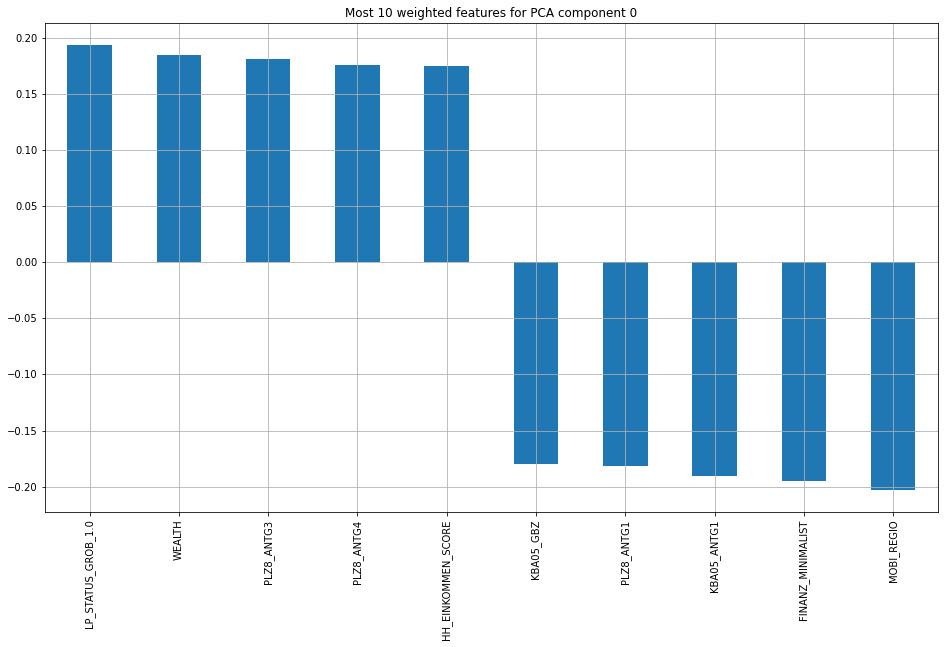

LP_STATUS_GROB_1.0    0.1930
WEALTH                0.1847
PLZ8_ANTG3            0.1809
PLZ8_ANTG4            0.1752
HH_EINKOMMEN_SCORE    0.1749
KBA05_GBZ            -0.1802
PLZ8_ANTG1           -0.1815
KBA05_ANTG1          -0.1903
FINANZ_MINIMALIST    -0.1951
MOBI_REGIO           -0.2031
Name: 0, dtype: float64


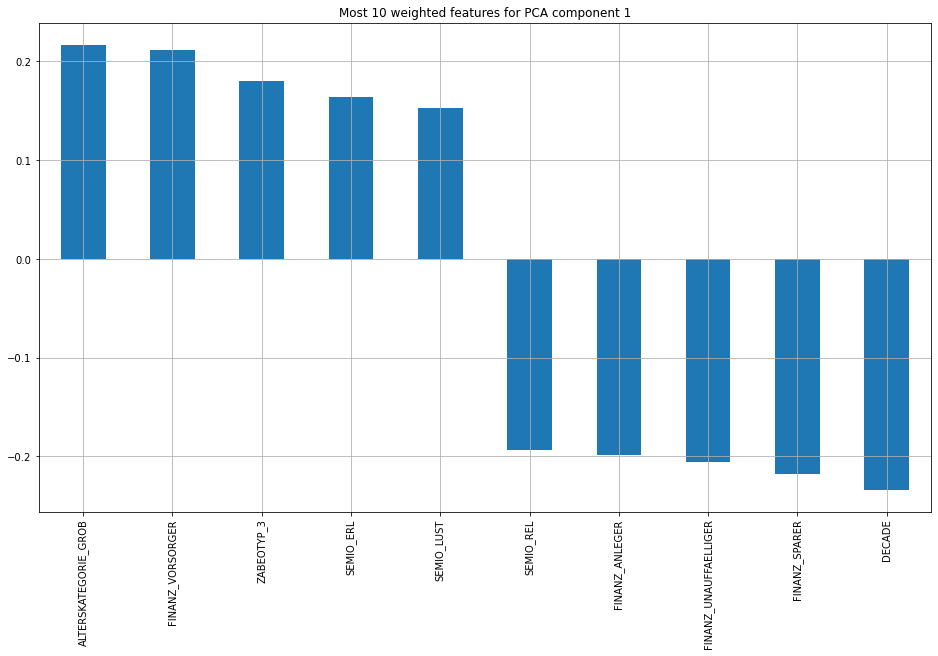

ALTERSKATEGORIE_GROB     0.2169
FINANZ_VORSORGER         0.2115
ZABEOTYP_3               0.1799
SEMIO_ERL                0.1640
SEMIO_LUST               0.1524
SEMIO_REL               -0.1931
FINANZ_ANLEGER          -0.1985
FINANZ_UNAUFFAELLIGER   -0.2058
FINANZ_SPARER           -0.2175
DECADE                  -0.2335
Name: 1, dtype: float64


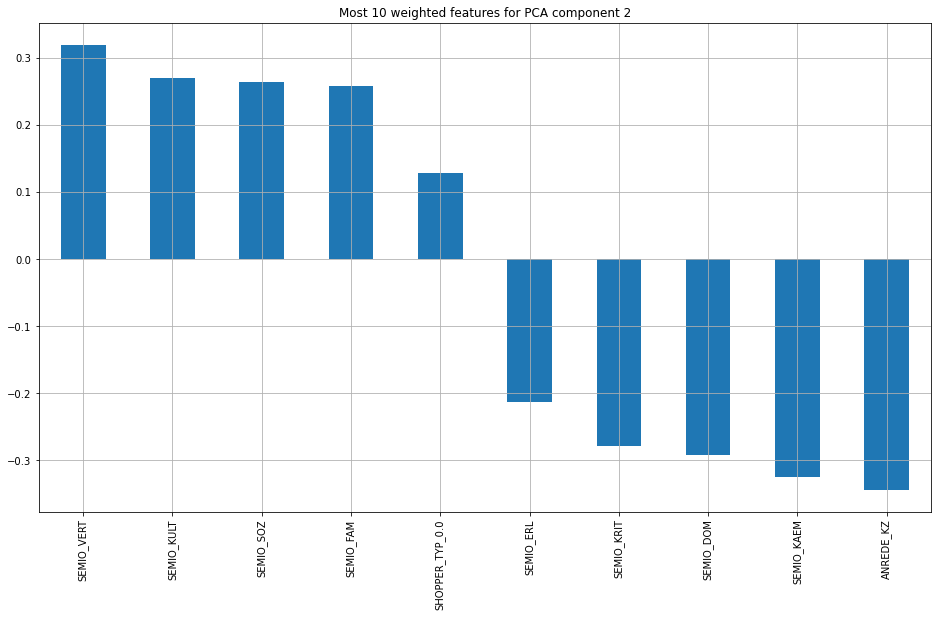

SEMIO_VERT         0.3193
SEMIO_KULT         0.2699
SEMIO_SOZ          0.2651
SEMIO_FAM          0.2587
SHOPPER_TYP_0.0    0.1293
SEMIO_ERL         -0.2128
SEMIO_KRIT        -0.2781
SEMIO_DOM         -0.2926
SEMIO_KAEM        -0.3241
ANREDE_KZ         -0.3441
Name: 2, dtype: float64


In [66]:
# Map weights for the first, second and third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

def pca_weights(df, pca, component_no, show_plot=False):
    
    pca_weights = pd.DataFrame(np.round(pca.components_, 4), columns=df.keys()).iloc[component_no].sort_values(ascending=False)
    pca_weights = pd.concat([pca_weights.head(5), pca_weights.tail(5)])
    
    if show_plot:
        # Plot the result
        pca_weights.plot(kind='bar', 
                  title='Most 10 weighted features for PCA component %s'%component_no)
        plt.grid()
        plt.show()
    print(pca_weights)
    return pca_weights

for comp in range(3):
    pca_weights(azdias_clean, pca, comp, show_plot=True)

### Discussion 2.3: Interpret Principal Components

#### 1st Principal Component 
* Weights (sorted descending) of the first principal component across different features and its interpretation based on Data_Dictionary.md

|No.	|value		|feature_name		|feature_description 							|No.	|values		|feature_name		|feature_description|
|-	|-			|-					|-												|-		|-			|-					|-|
|1.	|0.1930 	|**LP_STATUS_GROB_1.0**	|low-income earners								|1.		|-0.2031	|**MOBI_REGIO**			|Movement patterns|
|2.	|0.1847 	|**WEALTH**				|Wealth Typology								|2.		|-0.1951	|**FINANZ_MINIMALIST**			|low financial interest|
|3.	|0.1809 	|**PLZ8_ANTG3**			|Number of 6-10 family houses in the PLZ8 region|3.		|-0.1903	|**KBA05_ANTG1**		|Number of 1-2 family houses in the microcell|
|4.	|0.1752 	|**PLZ8_ANTG4**			|Number of 10+ family houses in the PLZ8 region	|4.		|-0.1815	|**PLZ8_ANTG1**	|Number of 1-2 family houses in the PLZ8 region|
|5.	|0.1749 	|**HH_EINKOMMEN_SCORE**	|Estimated household net income					|5.		|-0.1802	|**KBA05_GBZ**			|Number of buildings in the microcell|

#### 2nd Principal Component 
* Weights (sorted descending) of the second principal component across different features and its interpretation based on Data_Dictionary.md

|No.|value	|feature_name			|feature_description 						|No.	|values	|feature_name		|feature_description|
|-	|-		|-						|-											|-		|-		|-					|-|
|1.	|0.2169	|**ALTERSKATEGORIE_GROB**	|Estimated age based on given name analysis	|1.		|-0.2335|**DECADE**			|decade between 1940s & 1990s|
|2.	|0.2115|**FINANZ_VORSORGER**		|Financial typology: be prepared			|2.		|-0.2175|**FINANZ_SPARER**			|Financial typology:money-saver|
|3.	|0.1799|**ZABEOTYP_3**				|Energy consumption typology:fair supplied	|3.		|-0.2058|**FINANZ_UNAUFFAELLIGER**		|Financial typology:inconspicuous|
|4.	|0.1640|**SEMIO_ERL**				|Personality typology:event-oriented		|4.		|-0.1985|**FINANZ_ANLEGER**	|Financial typology:investor|
|5.	|0.1524|**SEMIO_LUST**				|Personality typology:sensual-minded		|5.		|-0.1931|**SEMIO_REL**			|Personality typology:religious|

#### 3rd Principal Component 
* Weights (sorted descending) of the third principal component across different features and its interpretation based on Data_Dictionary.md

|No.|value	|feature_name	|feature_description 								|No.|values	|feature_name			|feature_description
|-	|-		|-				|-													|-	|-		|-						|-
|1.	|0.3193 |**SEMIO_VERT**		|Personality typology:dreamful					|1.	|-0.3441|**ANREDE_KZ**			|Gender
|2.	|0.2699 |**SEMIO_KULT**		|Personality typology:cultural-minded			|2.	|-0.3241|**SEMIO_KAEM**			|Personality typology:combative attitude
|3.	|0.2651 |**SEMIO_SOZ**		|Personality typology:socially-minded			|3.	|-0.2926|**SEMIO_DOM**		|Personality typology:dominant-minded
|4.	|0.2587 |**SEMIO_FAM**		|Personality typology:family-minded				|4.	|-0.2781|**SEMIO_KRIT**	|Personality typology:critical-minded
|5.	|0.1293 |**SHOPPER_TYP_0.0**|Shopper typology:external supplied hedonists	|5.	|-0.2128|**SEMIO_ERL**			|Personality typology:event-oriented

#### Observations:
Here I noticed the dominant influence of personality (both directions), finance (inversely proportional) and number of occupants in a house (proportional).

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [67]:
def get_kmeans_score(data, center):
    '''
    returns the kmeans score regarding SSE for points to centers
    INPUT:
        data - the dataset you want to fit kmeans to
        center - the number of centers you want (the k value)
    OUTPUT:
        score - the SSE score for the kmeans model fit to the data
    '''
    #instantiate kmeans
    kmeans = KMeans(n_clusters=center)

    # Then fit the model to your data using the fit method
    model = kmeans.fit(data)

    # Obtain a score related to the model fit
    score = np.abs(model.score(data))

    return score

In [68]:
# Over a number of different cluster counts...

start_time = time.time()

centers = list(range(10,31))
scores = []
for center in centers:
    score = get_kmeans_score(azdias_pca, center)
    scores.append(score)
    
print("--- Run time: %s mins ---" % np.round(((time.time() - start_time)/60),2))

--- Run time: 30.19 mins ---


In [70]:
from kneed import KneeLocator

ng_knees = []
n_simulations = 100

for _ in range(n_simulations):
    x, y = centers, scores
    kl = KneeLocator(x, y, direction='increasing', curve='concave', S=1.0, interp_method='polynomial', online=True)
    ng_knees.append(kl.knee)

np.mean(ng_knees)

10.0

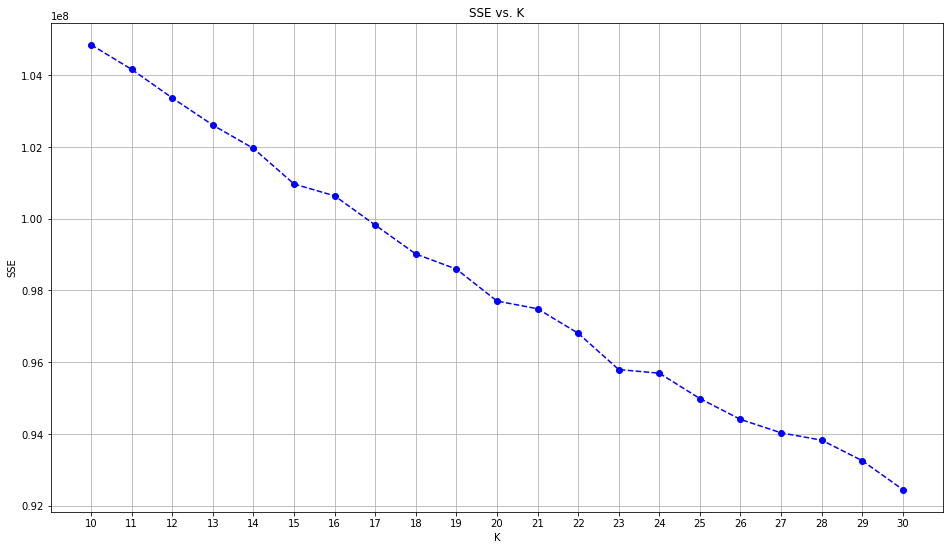

In [96]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

plt.plot(centers, scores, marker='o', linestyle='--', color='b')
plt.xlabel('K') # number of centriods/centers/clusters
plt.xticks(centers)
plt.ylabel('SSE') # score
plt.title('SSE vs. K')
plt.grid()
plt.show()

In [97]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

center = 20
kmeans = KMeans(n_clusters=center)
model = kmeans.fit(azdias_pca)
population_labels = model.predict(azdias_pca)

### Discussion 3.1: Apply Clustering to General Population

Although the knee-point wasn't so obvious, I decided to use the average within-cluster distances and hence chose k-value of 19 and re-fit a KMeans instance to perform the clustering operation.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [98]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv',sep=';')
customers.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,2,0,4.0,1,1,20.0,5.0,2.0,2.0,10.0,5.0,1,4,5.0,6,5,2,6,6,7,3,4,1,3,1,1,2,1,3,0.0,0.0,1,3,10.0,2.0,0.0,1.0,NaN,6.0,9.0,1.0,0.0,1.0,5.0,1992.0,W,7.0,1,1A,13,2.0,2.0,0.0,0.0,0.0,4.0,3.0,2.0,4.0,4.0,1.0,4.0,3.0,1.0,1201.0,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,2,0,NaN,0,1,NaN,NaN,NaN,NaN,NaN,NaN,1,0,NaN,3,6,2,6,7,5,3,4,1,3,3,2,4,1,3,0.0,0.0,1,3,11.0,3.0,0.0,NaN,NaN,0.0,9.0,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,2,0,3.0,1,2,13.0,3.0,1.0,1.0,10.0,5.0,1,4,5.0,2,2,1,3,3,7,7,1,2,7,5,6,4,1,1,0.0,0.0,2,3,6.0,1.0,0.0,1.0,NaN,6.0,9.0,1.0,0.0,8.0,1.0,1992.0,W,2.0,5,5D,34,2.0,2.0,0.0,0.0,0.0,3.0,7.0,4.0,1.0,3.0,3.0,3.0,1.0,7.0,433.0,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1,4,1,2.0,5,1,5,2,1,2,6,0,10.0,0,2,0.0,0.0,0.0,0.0,9.0,4.0,1,1,3.0,6,5,3,4,7,5,3,4,3,3,3,3,3,4,0,0.0,0.0,1,1,8.0,0.0,0.0,4.0,NaN,NaN,9.0,0.0,NaN,2.0,2.0,1992.0,W,7.0,4,4C,24,3.0,0.0,0.0,0.0,1.0,4.0,7.0,1.0,7.0,4.0,3.0,4.0,2.0,6.0,755.0,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,-1,3,1,6.0,3,1,4,4,5,2,2,1960,2.0,0,3,31.0,10.0,10.0,5.0,1.0,1.0,1,8,5.0,4,5,4,6,5,6,4,5,5,3,5,2,5,4,1,0.0,0.0,2,1,20.0,4.0,0.0,6.0,2.0,2.0,9.0,7.0,0.0,3.0,1.0,1992.0,W,3.0,7,7B,41,0.0,3.0,2.0,0.0,0.0,3.0,3.0,4.0,4.0,3.0,4.0,3.0,5.0,7.0,513.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0


In [99]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

# preprocessing
customers_clean = clean_data(customers)
customers_clean.head()

Pre-cleaned df shape: (191652, 85)
1 columns were dropped based on NaN threshold
0 rows were dropped based on NaN threshold
A total of 118 columns were added
Post cleaning df shape: (191652, 202)


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GEBURTSJAHR,GREEN_AVANTGARDE,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,AGER_TYP_1.0,AGER_TYP_2.0,AGER_TYP_3.0,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,FINANZTYP_1,FINANZTYP_2,FINANZTYP_3,FINANZTYP_4,FINANZTYP_5,FINANZTYP_6,GFK_URLAUBERTYP_1.0,GFK_URLAUBERTYP_2.0,GFK_URLAUBERTYP_3.0,GFK_URLAUBERTYP_4.0,GFK_URLAUBERTYP_5.0,GFK_URLAUBERTYP_6.0,GFK_URLAUBERTYP_7.0,GFK_URLAUBERTYP_8.0,GFK_URLAUBERTYP_9.0,GFK_URLAUBERTYP_10.0,GFK_URLAUBERTYP_11.0,GFK_URLAUBERTYP_12.0,LP_FAMILIE_FEIN_1.0,LP_FAMILIE_FEIN_2.0,LP_FAMILIE_FEIN_3.0,LP_FAMILIE_FEIN_4.0,LP_FAMILIE_FEIN_5.0,LP_FAMILIE_FEIN_6.0,LP_FAMILIE_FEIN_7.0,LP_FAMILIE_FEIN_8.0,LP_FAMILIE_FEIN_9.0,LP_FAMILIE_FEIN_10.0,LP_FAMILIE_FEIN_11.0,LP_FAMILIE_GROB_1.0,LP_FAMILIE_GROB_2.0,LP_FAMILIE_GROB_3.0,LP_FAMILIE_GROB_4.0,LP_FAMILIE_GROB_5.0,LP_STATUS_FEIN_1.0,LP_STATUS_FEIN_2.0,LP_STATUS_FEIN_3.0,LP_STATUS_FEIN_4.0,LP_STATUS_FEIN_5.0,LP_STATUS_FEIN_6.0,LP_STATUS_FEIN_7.0,LP_STATUS_FEIN_8.0,LP_STATUS_FEIN_9.0,LP_STATUS_FEIN_10.0,LP_STATUS_GROB_1.0,LP_STATUS_GROB_2.0,LP_STATUS_GROB_3.0,LP_STATUS_GROB_4.0,LP_STATUS_GROB_5.0,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,ZABEOTYP_1,ZABEOTYP_2,ZABEOTYP_3,ZABEOTYP_4,ZABEOTYP_5,ZABEOTYP_6,KK_KUNDENTYP_1.0,KK_KUNDENTYP_2.0,KK_KUNDENTYP_3.0,KK_KUNDENTYP_4.0,KK_KUNDENTYP_5.0,KK_KUNDENTYP_6.0,GEBAEUDETYP_1.0,GEBAEUDETYP_2.0,GEBAEUDETYP_3.0,GEBAEUDETYP_4.0,GEBAEUDETYP_6.0,GEBAEUDETYP_8.0,CAMEO_DEUG_2015_1,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,CAMEO_DEU_2015_1A,CAMEO_DEU_2015_1B,CAMEO_DEU_2015_1C,CAMEO_DEU_2015_1D,CAMEO_DEU_2015_1E,CAMEO_DEU_2015_2A,CAMEO_DEU_2015_2B,CAMEO_DEU_2015_2C,CAMEO_DEU_2015_2D,CAMEO_DEU_2015_3A,CAMEO_DEU_2015_3B,CAMEO_DEU_2015_3C,CAMEO_DEU_2015_3D,CAMEO_DEU_2015_4A,CAMEO_DEU_2015_4B,CAMEO_DEU_2015_4C,CAMEO_DEU_2015_4D,CAMEO_DEU_2015_4E,CAMEO_DEU_2015_5A,CAMEO_DEU_2015_5B,CAMEO_DEU_2015_5C,CAMEO_DEU_2015_5D,CAMEO_DEU_2015_5E,CAMEO_DEU_2015_5F,CAMEO_DEU_2015_6A,CAMEO_DEU_2015_6B,CAMEO_DEU_2015_6C,CAMEO_DEU_2015_6D,CAMEO_DEU_2015_6E,CAMEO_DEU_2015_6F,CAMEO_DEU_2015_7A,CAMEO_DEU_2015_7B,CAMEO_DEU_2015_7C,CAMEO_DEU_2015_7D,CAMEO_DEU_2015_7E,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
0,4.0,0.0,5.0,1.0,5.0,1.0,2.0,2.0,1949.773127,1.0,1.0,5.000000,6.0,5.0,2.0,6.0,6.0,7.0,3.0,4.0,1.0,3.0,1.0,1.0,2.0,1.0,0.0,0.0,10.0,2.0,0.0,1.000000,6.000000,9.0,1.000000,0.000000,5.0,1992.000000,0.000000,2.000000,2.000000,0.000000,0.000000,4.000000,3.000000,2.000000,4.000000,4.000000,1.000000,4.000000,3.000000,1.000000,1201.000000,3.000000,3.00000,1.000000,0.000000,5.000000,5.000000,1.000000,2.000000,1.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1

In [100]:
# Investigate NaN's
print('NaN count:',customers_clean.isna().sum().sum())

NaN count: 0


In [101]:
# further clean customers dataframe to fit based on the general population
list(set(azdias_clean.columns)-set(customers_clean.columns))

['GEBAEUDETYP_5.0']

In [102]:
# add ['GEBAEUDETYP_5.0'] column and assign 0 value which means unknown
customers_clean['GEBAEUDETYP_5.0'] = 0

In [103]:
list(set(customers_clean.columns)-set(azdias_clean.columns))

['AGER_TYP_1.0',
 'KK_KUNDENTYP_1.0',
 'KK_KUNDENTYP_5.0',
 'KK_KUNDENTYP_4.0',
 'AGER_TYP_2.0',
 'KK_KUNDENTYP_2.0',
 'AGER_TYP_3.0',
 'KK_KUNDENTYP_6.0',
 'KK_KUNDENTYP_3.0']

In [104]:
# drop additoinal columns to match original dataframe structure 
customers_clean.drop(list(set(customers_clean.columns)-set(azdias_clean.columns)), axis=1, inplace=True)

In [105]:
# confirm dropped columns task
list(set(customers_clean.columns)-set(azdias_clean.columns))

[]

In [106]:
# Apply feature scaling to the general population demographics data.

customers_scaled = scaler.fit_transform(customers_clean)

In [107]:
# feature transformation and clustering from the general
# demographics onto the customer data

customers_pca = pca.transform(customers_scaled)

In [108]:
# confirm number of components is similar to that selected of general population 
customers_pca.shape

(191652, 87)

In [109]:
# obtaining cluster predictions for the customer demographics data.

kmeans = KMeans(n_clusters=center)
model = kmeans.fit(customers_pca)
customer_labels = model.predict(customers_pca)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [110]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

# count unique values
unique, pop_counts = np.unique(population_labels, return_counts=True)
_, cust_counts = np.unique(customer_labels, return_counts=True)

# convert counts to percentage
population_percentage = pop_counts/sum(pop_counts)*100
customer_percentage = cust_counts/sum(cust_counts)*100


# create df's
df1 = pd.DataFrame(data={'population_percentage':population_percentage})
df2 = pd.DataFrame(data={'customer_percentage':customer_percentage})


frames = [df1, df2]
df = pd.concat(frames)
df.fillna(0,inplace=True)
df['label'] = df.index
df.reset_index(drop=True, inplace=True)
df['count_percentage'] = df['population_percentage'] + df['customer_percentage']
df.drop(['population_percentage','customer_percentage'], axis=1, inplace=True)
df['class'] = 'population'
df.loc[20:,'class'] = 'customer'
df.sample(5)

,label,count_percentage,class
12,12,5.062438,population
19,19,5.452793,population
4,4,6.395984,population
17,17,3.341729,population
20,0,24.224115,customer


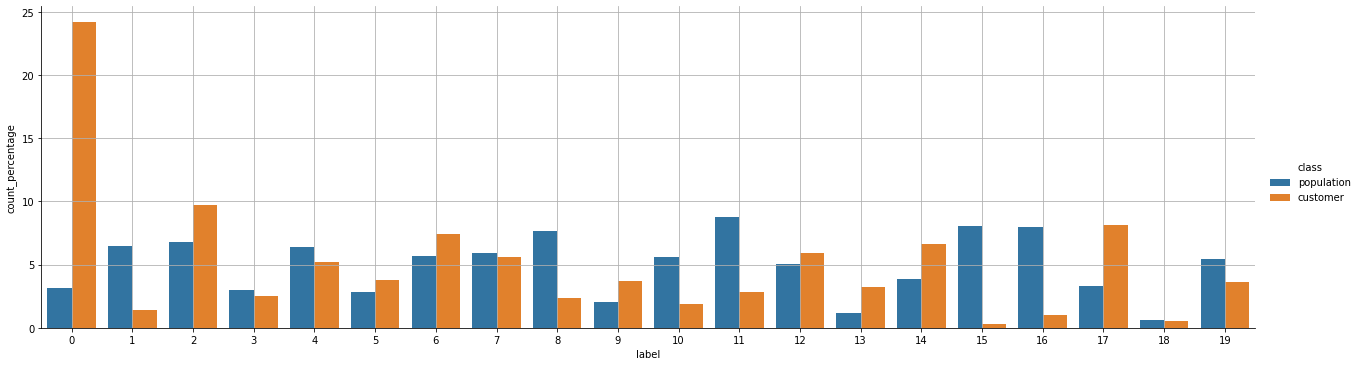

In [111]:
# plot the results
sns.catplot(x="label", y="count_percentage", hue="class", kind="bar", data=df, aspect=3.5);
plt.grid()

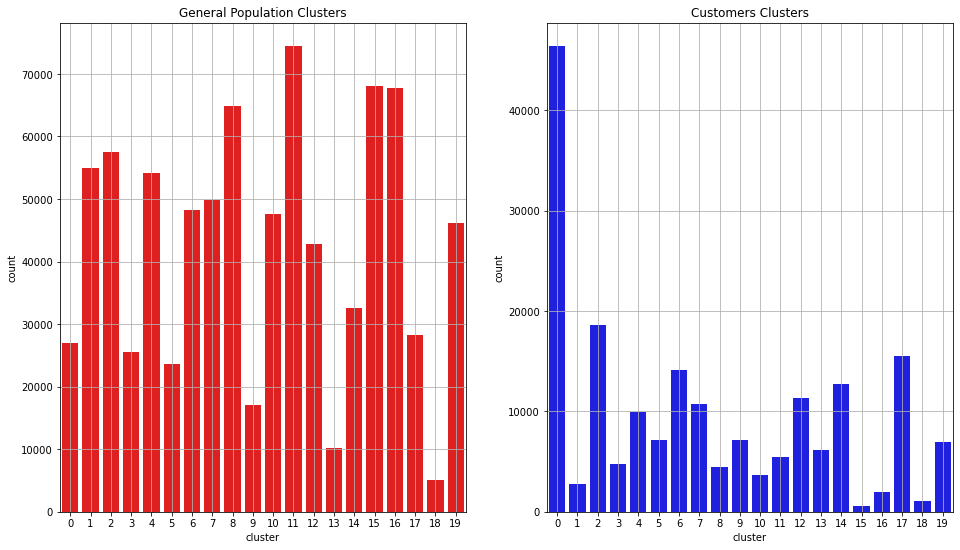

In [112]:
# another actual values visualization 

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.set_title('General Population Clusters')
sns.countplot(x = population_labels,ax=ax1, color= 'r')
ax1.set_xlabel('cluster')
ax1.grid()

ax2.set_title('Customers Clusters')
sns.countplot(x = customer_labels,ax=ax2, color='b')
ax2.set_xlabel('cluster')
ax2.grid()
plt.show()

In [147]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

# let's take customer cluster 0 as an example

customers_cluster_0 = pd.DataFrame(scaler.inverse_transform(pca.inverse_transform(customers_pca[np.where(customer_labels==0)])).round(), columns=azdias_clean.columns)
print('Data shape:', customers_cluster_0.shape)
customers_cluster_0.head()

Data shape: (46426, 194)


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GEBURTSJAHR,GREEN_AVANTGARDE,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,FINANZTYP_1,FINANZTYP_2,FINANZTYP_3,FINANZTYP_4,FINANZTYP_5,FINANZTYP_6,GFK_URLAUBERTYP_1.0,GFK_URLAUBERTYP_2.0,GFK_URLAUBERTYP_3.0,GFK_URLAUBERTYP_4.0,GFK_URLAUBERTYP_5.0,GFK_URLAUBERTYP_6.0,GFK_URLAUBERTYP_7.0,GFK_URLAUBERTYP_8.0,GFK_URLAUBERTYP_9.0,GFK_URLAUBERTYP_10.0,GFK_URLAUBERTYP_11.0,GFK_URLAUBERTYP_12.0,LP_FAMILIE_FEIN_1.0,LP_FAMILIE_FEIN_2.0,LP_FAMILIE_FEIN_3.0,LP_FAMILIE_FEIN_4.0,LP_FAMILIE_FEIN_5.0,LP_FAMILIE_FEIN_6.0,LP_FAMILIE_FEIN_7.0,LP_FAMILIE_FEIN_8.0,LP_FAMILIE_FEIN_9.0,LP_FAMILIE_FEIN_10.0,LP_FAMILIE_FEIN_11.0,LP_FAMILIE_GROB_1.0,LP_FAMILIE_GROB_2.0,LP_FAMILIE_GROB_3.0,LP_FAMILIE_GROB_4.0,LP_FAMILIE_GROB_5.0,LP_STATUS_FEIN_1.0,LP_STATUS_FEIN_2.0,LP_STATUS_FEIN_3.0,LP_STATUS_FEIN_4.0,LP_STATUS_FEIN_5.0,LP_STATUS_FEIN_6.0,LP_STATUS_FEIN_7.0,LP_STATUS_FEIN_8.0,LP_STATUS_FEIN_9.0,LP_STATUS_FEIN_10.0,LP_STATUS_GROB_1.0,LP_STATUS_GROB_2.0,LP_STATUS_GROB_3.0,LP_STATUS_GROB_4.0,LP_STATUS_GROB_5.0,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,ZABEOTYP_1,ZABEOTYP_2,ZABEOTYP_3,ZABEOTYP_4,ZABEOTYP_5,ZABEOTYP_6,GEBAEUDETYP_1.0,GEBAEUDETYP_2.0,GEBAEUDETYP_3.0,GEBAEUDETYP_4.0,GEBAEUDETYP_5.0,GEBAEUDETYP_6.0,GEBAEUDETYP_8.0,CAMEO_DEUG_2015_1,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,CAMEO_DEU_2015_1A,CAMEO_DEU_2015_1B,CAMEO_DEU_2015_1C,CAMEO_DEU_2015_1D,CAMEO_DEU_2015_1E,CAMEO_DEU_2015_2A,CAMEO_DEU_2015_2B,CAMEO_DEU_2015_2C,CAMEO_DEU_2015_2D,CAMEO_DEU_2015_3A,CAMEO_DEU_2015_3B,CAMEO_DEU_2015_3C,CAMEO_DEU_2015_3D,CAMEO_DEU_2015_4A,CAMEO_DEU_2015_4B,CAMEO_DEU_2015_4C,CAMEO_DEU_2015_4D,CAMEO_DEU_2015_4E,CAMEO_DEU_2015_5A,CAMEO_DEU_2015_5B,CAMEO_DEU_2015_5C,CAMEO_DEU_2015_5D,CAMEO_DEU_2015_5E,CAMEO_DEU_2015_5F,CAMEO_DEU_2015_6A,CAMEO_DEU_2015_6B,CAMEO_DEU_2015_6C,CAMEO_DEU_2015_6D,CAMEO_DEU_2015_6E,CAMEO_DEU_2015_6F,CAMEO_DEU_2015_7A,CAMEO_DEU_2015_7B,CAMEO_DEU_2015_7C,CAMEO_DEU_2015_7D,CAMEO_DEU_2015_7E,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
0,2.0,1.0,3.0,4.0,3.0,5.0,5.0,3.0,1954.0,0.0,2.0,4.0,2.0,5.0,7.0,5.0,1.0,5.0,3.0,3.0,5.0,7.0,6.0,6.0,5.0,3.0,-0.0,1.0,13.0,2.0,0.0,2.0,4.0,9.0,6.0,0.0,3.0,1993.0,0.0,2.0,1.0,0.0,0.0,4.0,4.0,4.0,5.0,4.0,2.0,4.0,3.0,4.0,682.0,3.0,3.0,1.0,1.0,4.0,4.0,3.0,5.0,3.0,0.0,0.0,-0.0,-0.0,0.0,1.0,0.0,-0.0,-0.0,1.0,0.0,-0.0,0.0,0.0,0.0,0.0,1.0,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,0.0,-0.0,-0.0,0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,0.0,-0.0,0.0,-0.0,-0.0,0.0,-0.0,0.0,0.0,-0.0,-0.0,0.0,-0.0,0.0,0.0,-0.0,2.0,1.0,2.0,2.0,0.0
1,2.0,1.0,3.0,4.0,3.0,5.0,5.0,3.0,1954.0,0.0,2.0,4.0,2.0,5.0,7.0,5.0,1.0,5.0,4.0,3.0,4.0,7

* Statistical analysis of cluster 0 of interest to the company based
1. Estimated age: 30 - 45 yrs
2. Gender: Dominated by females
3. Financial: be prepared, home ownership, and low financial interest
6. Return type: conservative Low-Returner
8. event-oriented and cultural-minded: high affinity
9. dreamful: highest affinity
11. Birthdate of head of household: 1960-01-01 to 1964-12-31
12. Number of adults in household: 2
13. Estimated household net income: very high income
14. Likelihood of children in household: average
19. Number of family houses in the microcell: average 1-2 and less 3-5
20. Distance to nearest urban center: 30 -  40 km
24. Online affinity: high
29. Customer journey: Advertising-Enthusiast with restricted Cross-Channel-Behaviour
30. Vacation habits: Nature fans
32. Social status: minimalistic high-income earners or average earners (maps to 3-5 in fine scale)
35. Dominating movement of person's youth: 40s - war years (Mainstream, E+W)
36. Wealth: Comfortable Households
37. Life Stage: Pre-Family Couples & Singles

In [145]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

# let's take customer cluster 15 as an example

customers_cluster_15 = pd.DataFrame(scaler.inverse_transform(pca.inverse_transform(customers_pca[np.where(customer_labels==15)])).round(), columns=azdias_clean.columns)
customers_cluster_15.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GEBURTSJAHR,GREEN_AVANTGARDE,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,FINANZTYP_1,FINANZTYP_2,FINANZTYP_3,FINANZTYP_4,FINANZTYP_5,FINANZTYP_6,GFK_URLAUBERTYP_1.0,GFK_URLAUBERTYP_2.0,GFK_URLAUBERTYP_3.0,GFK_URLAUBERTYP_4.0,GFK_URLAUBERTYP_5.0,GFK_URLAUBERTYP_6.0,GFK_URLAUBERTYP_7.0,GFK_URLAUBERTYP_8.0,GFK_URLAUBERTYP_9.0,GFK_URLAUBERTYP_10.0,GFK_URLAUBERTYP_11.0,GFK_URLAUBERTYP_12.0,LP_FAMILIE_FEIN_1.0,LP_FAMILIE_FEIN_2.0,LP_FAMILIE_FEIN_3.0,LP_FAMILIE_FEIN_4.0,LP_FAMILIE_FEIN_5.0,LP_FAMILIE_FEIN_6.0,LP_FAMILIE_FEIN_7.0,LP_FAMILIE_FEIN_8.0,LP_FAMILIE_FEIN_9.0,LP_FAMILIE_FEIN_10.0,LP_FAMILIE_FEIN_11.0,LP_FAMILIE_GROB_1.0,LP_FAMILIE_GROB_2.0,LP_FAMILIE_GROB_3.0,LP_FAMILIE_GROB_4.0,LP_FAMILIE_GROB_5.0,LP_STATUS_FEIN_1.0,LP_STATUS_FEIN_2.0,LP_STATUS_FEIN_3.0,LP_STATUS_FEIN_4.0,LP_STATUS_FEIN_5.0,LP_STATUS_FEIN_6.0,LP_STATUS_FEIN_7.0,LP_STATUS_FEIN_8.0,LP_STATUS_FEIN_9.0,LP_STATUS_FEIN_10.0,LP_STATUS_GROB_1.0,LP_STATUS_GROB_2.0,LP_STATUS_GROB_3.0,LP_STATUS_GROB_4.0,LP_STATUS_GROB_5.0,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,ZABEOTYP_1,ZABEOTYP_2,ZABEOTYP_3,ZABEOTYP_4,ZABEOTYP_5,ZABEOTYP_6,GEBAEUDETYP_1.0,GEBAEUDETYP_2.0,GEBAEUDETYP_3.0,GEBAEUDETYP_4.0,GEBAEUDETYP_5.0,GEBAEUDETYP_6.0,GEBAEUDETYP_8.0,CAMEO_DEUG_2015_1,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,CAMEO_DEU_2015_1A,CAMEO_DEU_2015_1B,CAMEO_DEU_2015_1C,CAMEO_DEU_2015_1D,CAMEO_DEU_2015_1E,CAMEO_DEU_2015_2A,CAMEO_DEU_2015_2B,CAMEO_DEU_2015_2C,CAMEO_DEU_2015_2D,CAMEO_DEU_2015_3A,CAMEO_DEU_2015_3B,CAMEO_DEU_2015_3C,CAMEO_DEU_2015_3D,CAMEO_DEU_2015_4A,CAMEO_DEU_2015_4B,CAMEO_DEU_2015_4C,CAMEO_DEU_2015_4D,CAMEO_DEU_2015_4E,CAMEO_DEU_2015_5A,CAMEO_DEU_2015_5B,CAMEO_DEU_2015_5C,CAMEO_DEU_2015_5D,CAMEO_DEU_2015_5E,CAMEO_DEU_2015_5F,CAMEO_DEU_2015_6A,CAMEO_DEU_2015_6B,CAMEO_DEU_2015_6C,CAMEO_DEU_2015_6D,CAMEO_DEU_2015_6E,CAMEO_DEU_2015_6F,CAMEO_DEU_2015_7A,CAMEO_DEU_2015_7B,CAMEO_DEU_2015_7C,CAMEO_DEU_2015_7D,CAMEO_DEU_2015_7E,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
0,3.0,0.0,5.0,2.0,3.0,2.0,2.0,1.0,1956.0,1.0,3.0,4.0,6.0,4.0,3.0,3.0,6.0,4.0,4.0,5.0,3.0,4.0,5.0,3.0,3.0,4.0,0.0,1.0,13.0,-0.0,-0.0,4.0,-1.0,9.0,-3.0,0.0,4.0,1992.0,0.0,3.0,1.0,0.0,-0.0,4.0,5.0,4.0,5.0,5.0,3.0,5.0,4.0,5.0,915.0,3.0,3.0,2.0,1.0,4.0,4.0,2.0,5.0,2.0,1.0,-1.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,1.0,-0.0,0.0,1.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,1.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,-1.0,-0.0,-0.0,1.0,-0.0,-0.0,0.0,-0.0,0.0,0.0,-0.0,-0.0,0.0,-0.0,0.0,1.0,0.0,0.0,-0.0,-0.0,1.0,1.0,0.0,-0.0,-0.0,1.0,0.0,0.0,0.0,-0.0,-0.0,1.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,1.0,-0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,0.0,3.0,1.0,3.0,2.0,0.0
1,3.0,1.0,4.0,2.0,3.0,3.0,4.0,1.0,1956.0,1.0,2.0,3.0,2.0,4.0,3.0,5

* Statistical analysis of cluster 0 (NOT) of interest to the company based
1. Estimated age: mode is 46 - 60 years old
2. Gender: evenly distributed 
3. Financial: money-saver, and less of investor
6. Return type: incentive-receptive Normal-Returner
7. religious: high affinity
8. tradional-minded, event-oriented and cultural-minded: high affinity
9. dreamful: highest affinity
11. Birthdate of head of household: 1955-01-01 to 1959-12-31
12. Number of adults in household: 0 or very little
13. Estimated household net income: average income
14. Likelihood of children in household: likely
19. Number of family houses in the microcell: 1-2
20. Distance to nearest urban center: 40 -  50 km
24. Online affinity: very high to highest
29. Customer journey: advertising interested Online-shopper
30. Vacation habits: Package tour travelers
32. Social status: houseowners/top earners
35. Dominating movement of person's youth: 40s - reconstruction years (Avantgarde, E+W)
36. Wealth: Prosperous Households
37. Life Stage: Young Couples With Children

### Discussion 3.3: Compare Customer Data to Demographics Data

1. As cluster 0 is having a higher proportion of persons for the customer data compared to the general population, then that suggests the people in that cluster to be a target audience for the company.
2. As cluster 15 is having a lower proportion of persons for the customer data compared to the general population, then that suggests the people in that cluster **NOT** to be a target audience for the company.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.